## Final Project Submission

Please fill out:
* Student name: Aaron Lee
* Student pace: self paced
* Scheduled project review date/time: 7/22/2020, 9:00AM CT
* Instructor name: Jeff Herman
* Blog post URL: https://medium.com/me/stats/post/62425ac4eafa

#  Questions for this project
- What is the price of a hypothetical home, given attributes. Use a multivariable regression model.
- How does location affect the home price in King County.  Use folium.
- How much should you spend on a renovation and still expect a return on investment.

In [47]:
# Import libraries used in this project.
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import folium
import folium.plugins
import branca
import branca.colormap as cm
from shapely.geometry import Polygon, Point, MultiPolygon, shape, GeometryCollection

import json

import pickle

import datetime

import statsmodels.api as sm
import statsmodels.formula.api as smf
import scipy.stats as stats
import statsmodels.stats.api as sms
from statsmodels.formula.api import ols

from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score

%matplotlib inline

## Import the data from our EDA

In [48]:
# Unpickle the data from the first section
kc2 = pd.read_pickle('01_eda_out.pkl')
kc2.describe()
kc2.columns

Index(['id', 'date', 'price', 'bedrooms', 'bathrooms', 'sqft_living',
       'sqft_lot', 'floors', 'waterfront', 'view', 'condition', 'grade',
       'sqft_above', 'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode',
       'lat', 'long', 'sqft_living15', 'sqft_lot15', 'month', 'has_basement',
       'longlat', 'points', 'school_district', 'school_score', 'nearest_water',
       'downtown_dist', 'nearest_bucks', 'views_nearby'],
      dtype='object')

## Choose the columns I want to use to answer my questions.
### Leave out the following:
- floors.  The floors is a function of home style, era, and area mostly. Should be teased out in other categories
- sqft_above, sqft_basement.  We will use the sqft_living as the size of the home and ignore others
- yr_built.  We will use renovated year instead since we addressed no renovation issue to include year built
- date.  All dates are within a single year range.  We could investigate month or week though to see how it affects price
- waterfront.  We now have nearest_water and view is a good surrogate.  Highly correlated with view.
- nearest 15 data.  We will use sqft data only.  I feel like this could affect the model if we include too many sqft.  Can alter later maybe.  Highly correlated.
- condition (1 to 5) - will filter out bad condition, but won't use it for model


### We will investigate:
- view: seems important
- grade: measure of updates, features, and style of home
- price: will be our feature of interest
- bedrooms
- bathrooms
- sqft_living (size of home)
- nearest_water (incorporates waterfront data also)
- zipcode 
- yr_renovated (inclueds yr_built data)
- school_district (may use it instead of zip if the data looks good)
- lat, long, but will change it to map Point objects
#### Added columns:
- dist_water
- dist_downtown
- school_district
- school_score
- month
- nearby_views

In [49]:
sorted(kc2['yr_built'].unique())  # looks good, no change here
kc2.count()   #21143 total to start

kc2.loc[kc2['price'] > 150000].count()  #drops the bottom 10000

kc2.loc[(kc2['price'] < 1500000)].count()  # drops the top 10000

id                 20615
date               20615
price              20615
bedrooms           20615
bathrooms          20615
sqft_living        20615
sqft_lot           20615
floors             20615
waterfront         20615
view               20615
condition          20615
grade              20615
sqft_above         20615
sqft_basement      20615
yr_built           20615
yr_renovated       20615
zipcode            20615
lat                20615
long               20615
sqft_living15      20615
sqft_lot15         20615
month              20615
has_basement       20615
longlat            20615
points             20615
school_district    20611
school_score       20611
nearest_water      20615
downtown_dist      20615
nearest_bucks      20615
views_nearby       20615
dtype: int64

In [63]:
# Our model will predict family homes, so we will tailor our dataset to match that.
# We currently have homes over 7 million dollars which are outliers

## Get rid of any odd data or extreme outliers that we might be using
sorted(kc2['yr_built'].unique())  # looks good, no change here


# Price 
kc2 = kc2.loc[(kc2['price'] > 120000) & (kc2['price'] < 2000000)]
# We lose ~2000 (5% of data) but drastically improve the modeling
# most losses are on the high end of price range

# Bedrooms
sorted(kc2['bedrooms'].unique())  
# We have a place with 33 rooms!!  (typo?). Let's drop it
# Also looking at other many bedroomed places, there are a few inconsistencies, 
# eg.  9 bedroom 2 bath and 8 bedroom with 2200 sqft.
# I decided to drop anything more than 5 beds.  Narrows it to more typical family homes. 
kc2 = kc2.loc[(kc2['bedrooms'] >= 2) & (kc2['bedrooms'] <= 5)]  
# We lose another ~1000


# Bathrooms
sorted(kc2['bathrooms'].unique())
# Family home would expect 1.5 at least
kc2 = kc2.loc[(kc2['bathrooms'] >= 1) & (kc2['bathrooms'] <= 5)]  
# Lose another ~1000

# Condition
sorted(kc2['condition'].unique())  # Looks good
# Get rid of poor condition homes
kc2 = kc2.loc[kc2['condition'] >= 3]
print(len(kc2))

# Zipcode
sorted(kc2['zipcode'].unique())  # looks good

# sqft_living
#sorted(kc['sqft_living'].unique())[:100]  # looks at small and large homes
# will chop off the tails.  Under 1500 and over 5500.  These are probably more suitable to our model and reflect
# typical homes we are interested in.
kc2 = kc2.loc[(kc2['sqft_living'] > 1000) & (kc2['sqft_living'] < 5500)]
# lose another ~1500
print(len(kc2))



# Had trouble with school score of zero
kc2['school_score'] = kc2['school_score'].apply(lambda x: x + 1)
kc2 = kc2.dropna()

kc2['quarter'] = kc2['month'] // 4 + 1


kc2['has_basement'] = kc2['sqft_basement'].apply(lambda x: 1 if x > 0 else 0)

kc2.isna().sum()

kc2.has_basement.unique()
sns.set_context('paper')


18912
18912


## Single variable regression analysis

We will start by looking to see if any of our chosen

BEDROOMS BEDROOMS BEDROOMS BEDROOMS BEDROOMS 
Housing Data - Regression Analysis and Diagnostics for Price~bedrooms
                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.074
Model:                            OLS   Adj. R-squared:                  0.073
Method:                 Least Squares   F-statistic:                     1501.
Date:                Mon, 20 Jul 2020   Prob (F-statistic):          5.57e-316
Time:                        14:55:40   Log-Likelihood:            -2.6345e+05
No. Observations:               18912   AIC:                         5.269e+05
Df Residuals:                   18910   BIC:                         5.269e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
---------------

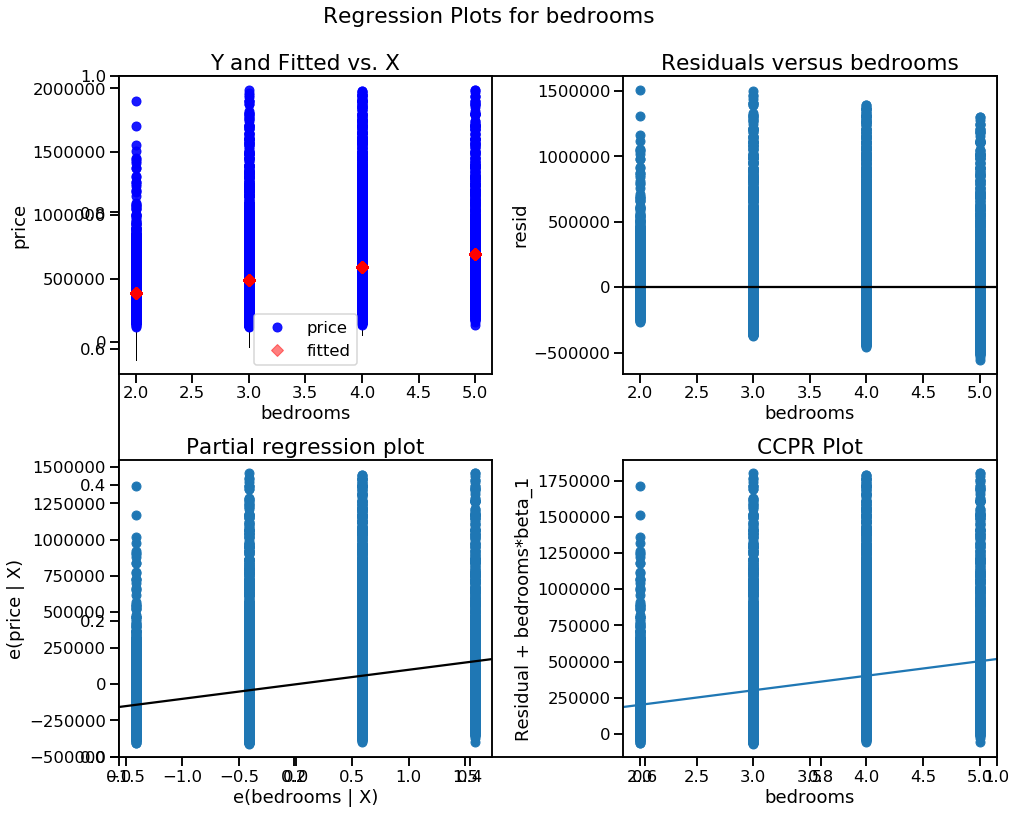

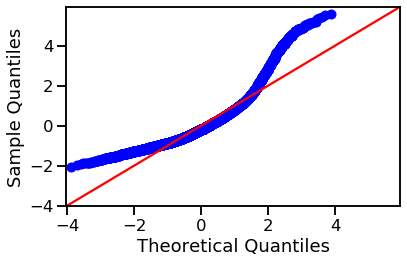

BATHROOMS BATHROOMS BATHROOMS BATHROOMS BATHROOMS 
Housing Data - Regression Analysis and Diagnostics for Price~bathrooms
                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.215
Model:                            OLS   Adj. R-squared:                  0.215
Method:                 Least Squares   F-statistic:                     5181.
Date:                Mon, 20 Jul 2020   Prob (F-statistic):               0.00
Time:                        14:55:43   Log-Likelihood:            -2.6188e+05
No. Observations:               18912   AIC:                         5.238e+05
Df Residuals:                   18910   BIC:                         5.238e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
---------

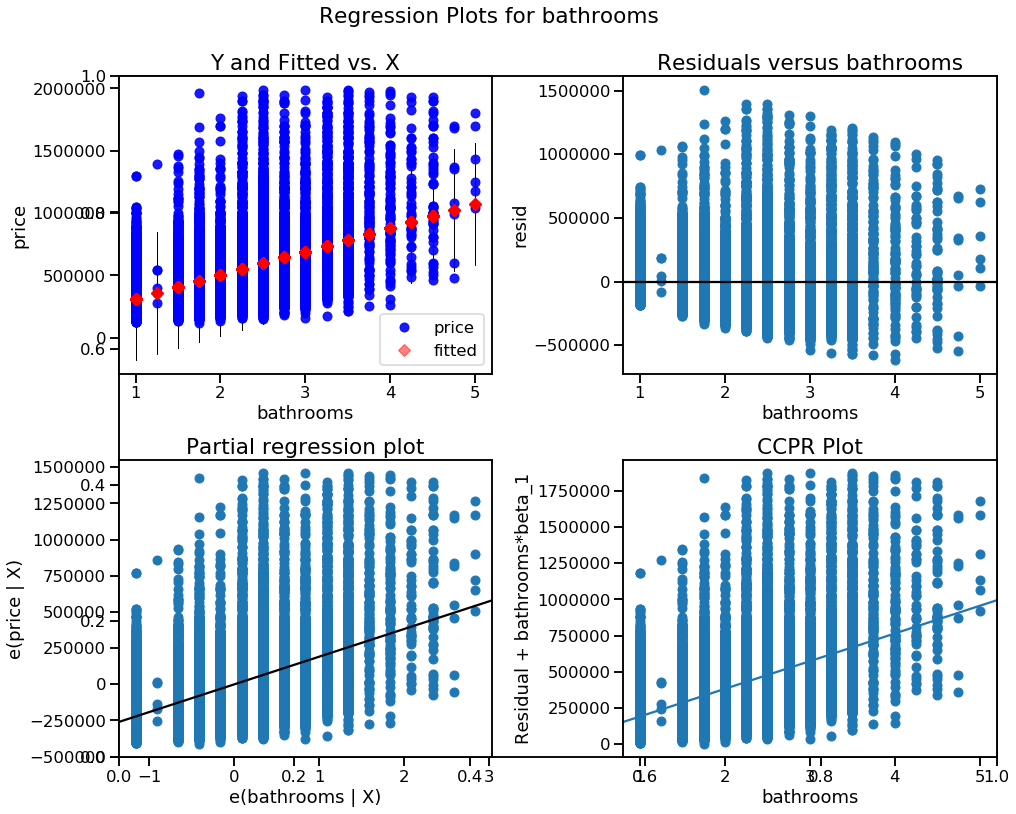

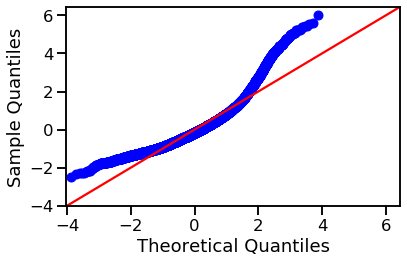

SQFT_LIVING SQFT_LIVING SQFT_LIVING SQFT_LIVING SQFT_LIVING 
Housing Data - Regression Analysis and Diagnostics for Price~sqft_living
                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.431
Model:                            OLS   Adj. R-squared:                  0.431
Method:                 Least Squares   F-statistic:                 1.434e+04
Date:                Mon, 20 Jul 2020   Prob (F-statistic):               0.00
Time:                        14:55:46   Log-Likelihood:            -2.5883e+05
No. Observations:               18912   AIC:                         5.177e+05
Df Residuals:                   18910   BIC:                         5.177e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.9

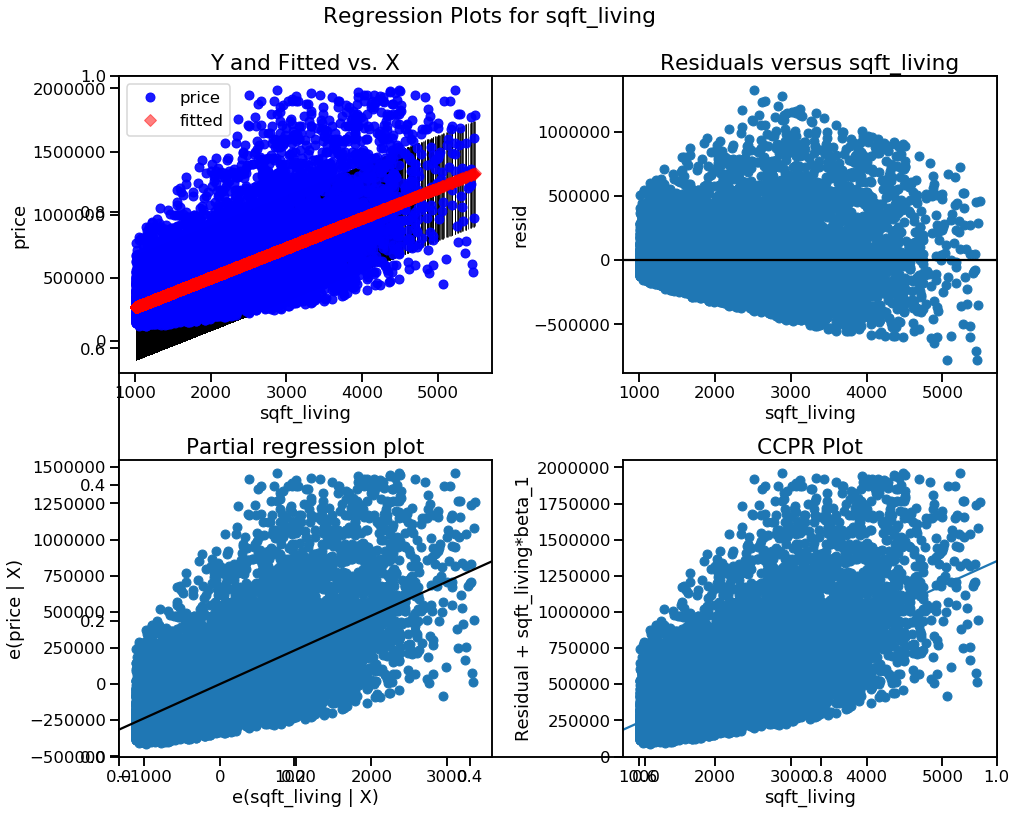

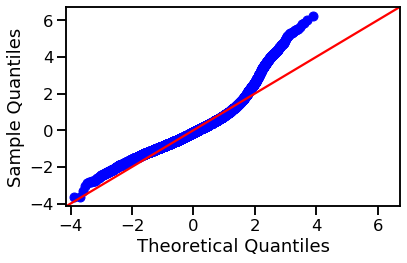

SQFT_LOT SQFT_LOT SQFT_LOT SQFT_LOT SQFT_LOT 
Housing Data - Regression Analysis and Diagnostics for Price~sqft_lot
                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.007
Model:                            OLS   Adj. R-squared:                  0.007
Method:                 Least Squares   F-statistic:                     128.4
Date:                Mon, 20 Jul 2020   Prob (F-statistic):           1.12e-29
Time:                        14:55:48   Log-Likelihood:            -2.6411e+05
No. Observations:               18912   AIC:                         5.282e+05
Df Residuals:                   18910   BIC:                         5.282e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
---------------

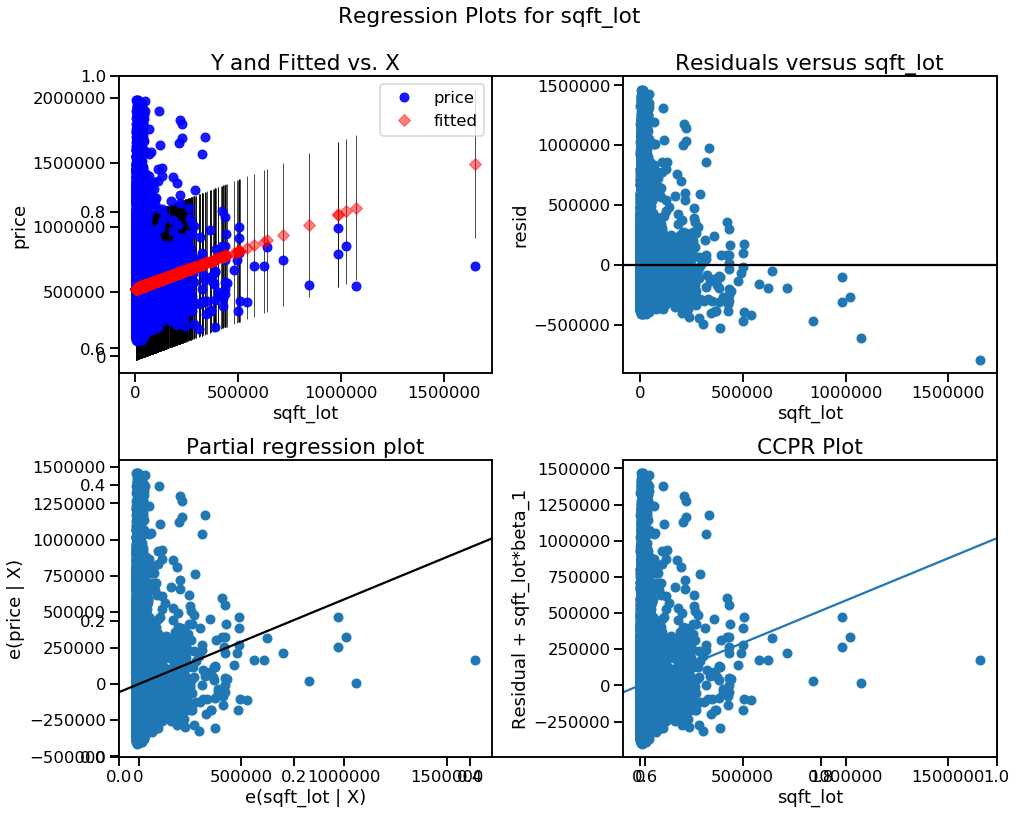

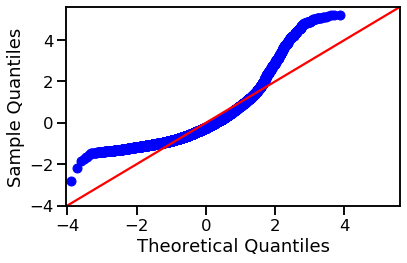

FLOORS FLOORS FLOORS FLOORS FLOORS 
Housing Data - Regression Analysis and Diagnostics for Price~floors
                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.058
Model:                            OLS   Adj. R-squared:                  0.058
Method:                 Least Squares   F-statistic:                     1162.
Date:                Mon, 20 Jul 2020   Prob (F-statistic):          3.76e-247
Time:                        14:55:51   Log-Likelihood:            -2.6361e+05
No. Observations:               18912   AIC:                         5.272e+05
Df Residuals:                   18910   BIC:                         5.272e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
---------------------------

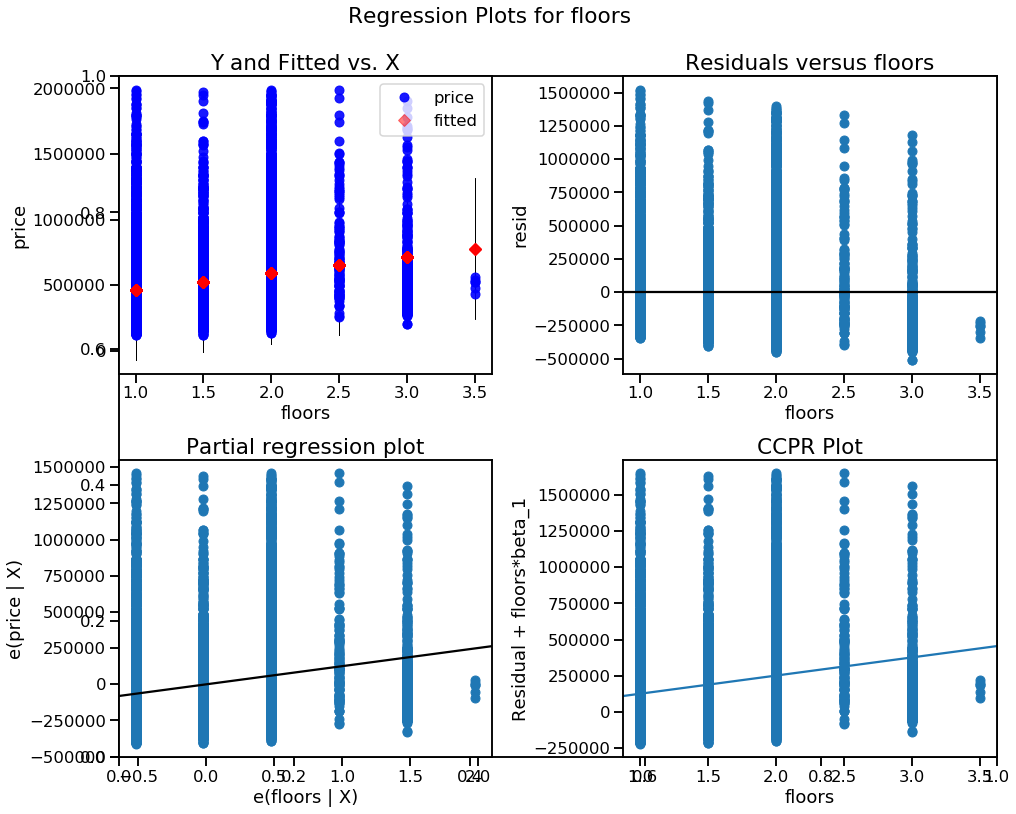

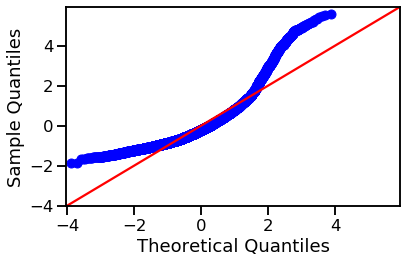

WATERFRONT WATERFRONT WATERFRONT WATERFRONT WATERFRONT 
Housing Data - Regression Analysis and Diagnostics for Price~waterfront
                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.021
Model:                            OLS   Adj. R-squared:                  0.021
Method:                 Least Squares   F-statistic:                     403.6
Date:                Mon, 20 Jul 2020   Prob (F-statistic):           7.82e-89
Time:                        14:55:54   Log-Likelihood:            -2.6397e+05
No. Observations:               18912   AIC:                         5.279e+05
Df Residuals:                   18910   BIC:                         5.280e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
---

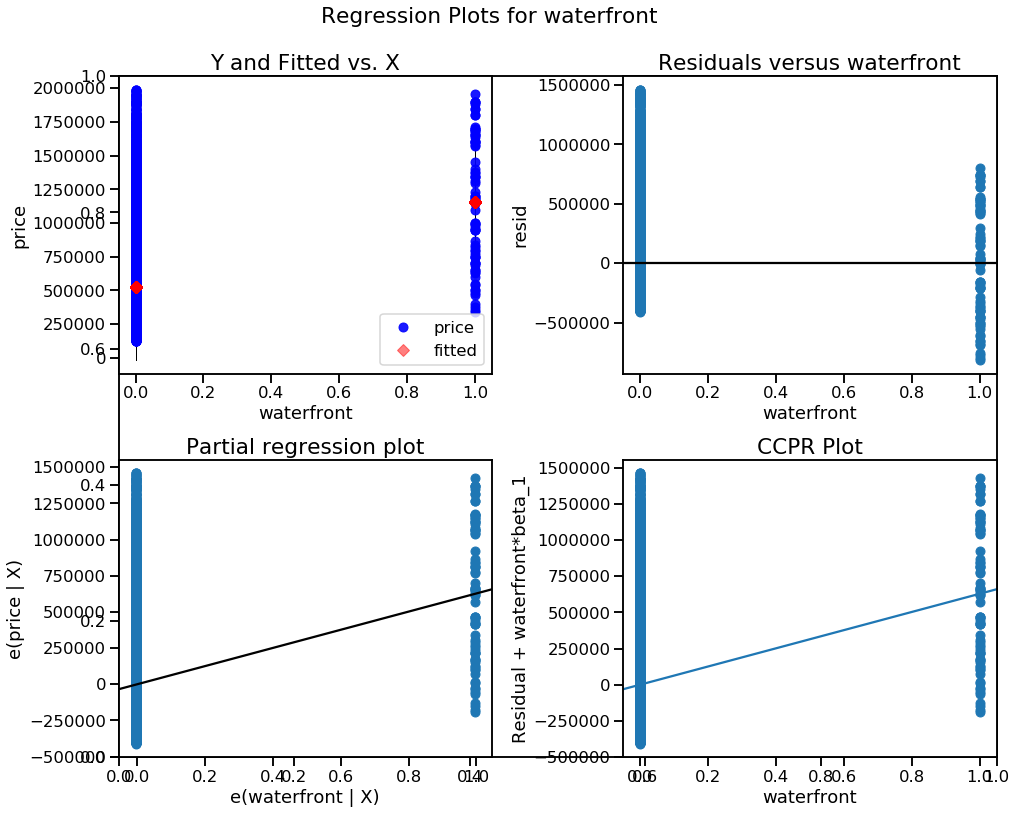

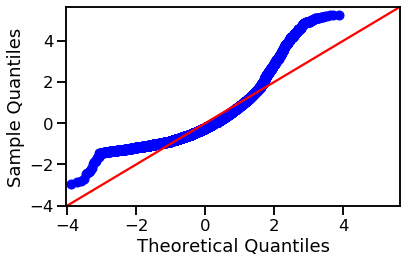

VIEW VIEW VIEW VIEW VIEW 
Housing Data - Regression Analysis and Diagnostics for Price~view
                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.112
Model:                            OLS   Adj. R-squared:                  0.112
Method:                 Least Squares   F-statistic:                     2393.
Date:                Mon, 20 Jul 2020   Prob (F-statistic):               0.00
Time:                        14:55:57   Log-Likelihood:            -2.6304e+05
No. Observations:               18912   AIC:                         5.261e+05
Df Residuals:                   18910   BIC:                         5.261e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------

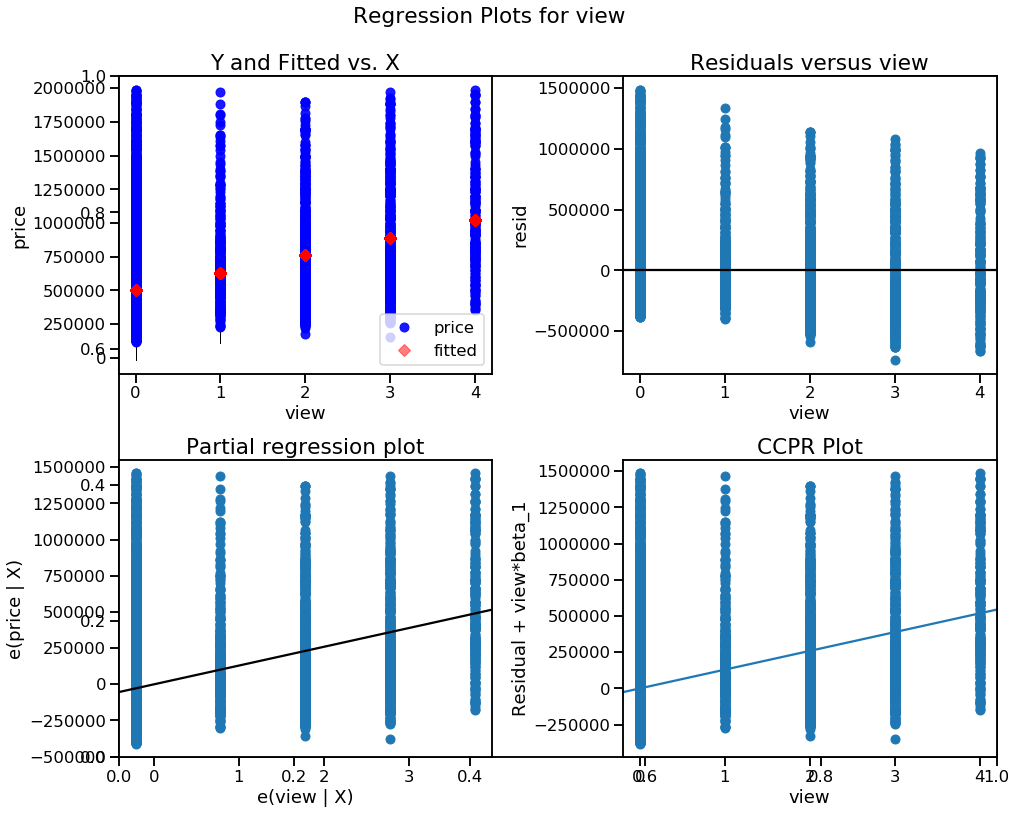

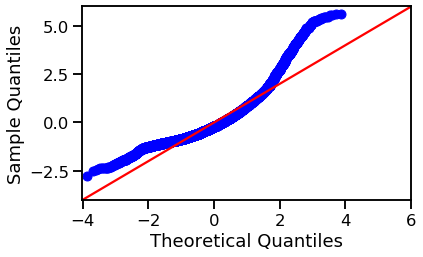

CONDITION CONDITION CONDITION CONDITION CONDITION 
Housing Data - Regression Analysis and Diagnostics for Price~condition
                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.001
Model:                            OLS   Adj. R-squared:                  0.001
Method:                 Least Squares   F-statistic:                     17.16
Date:                Mon, 20 Jul 2020   Prob (F-statistic):           3.46e-05
Time:                        14:56:03   Log-Likelihood:            -2.6416e+05
No. Observations:               18912   AIC:                         5.283e+05
Df Residuals:                   18910   BIC:                         5.283e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
---------

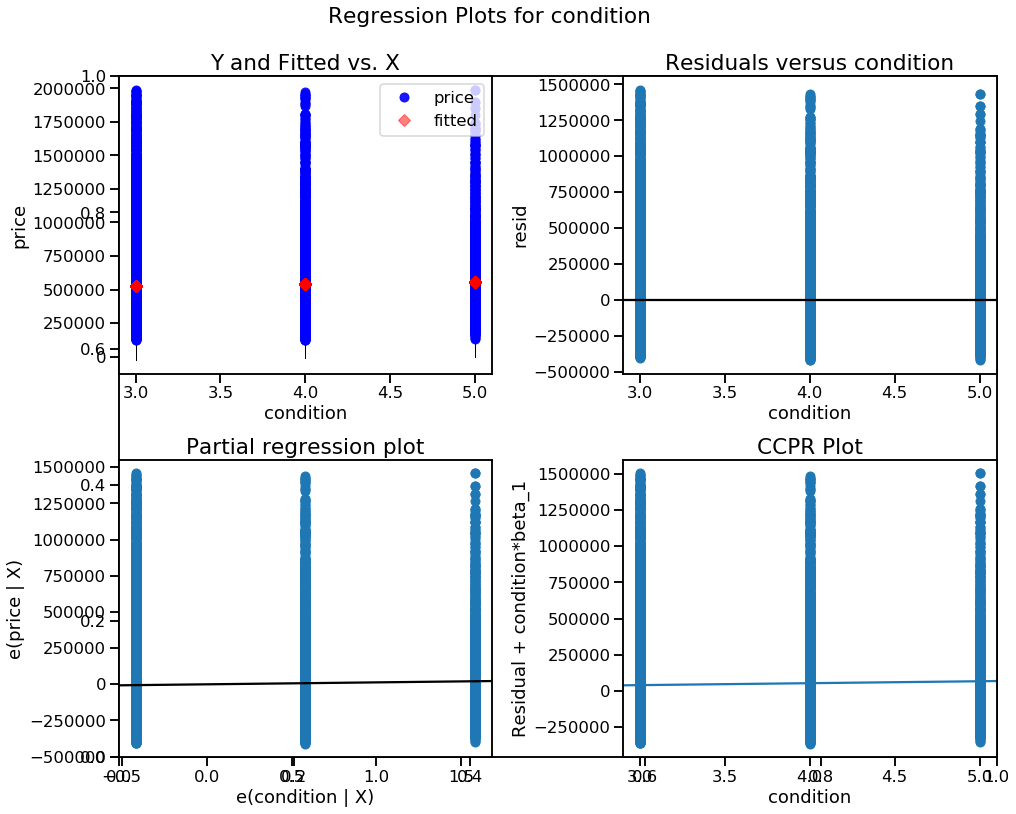

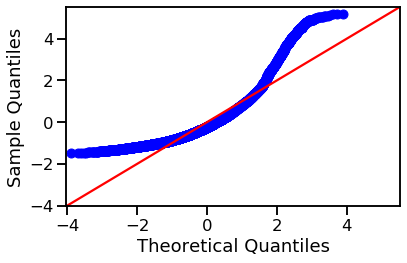

GRADE GRADE GRADE GRADE GRADE 
Housing Data - Regression Analysis and Diagnostics for Price~grade
                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.441
Model:                            OLS   Adj. R-squared:                  0.441
Method:                 Least Squares   F-statistic:                 1.492e+04
Date:                Mon, 20 Jul 2020   Prob (F-statistic):               0.00
Time:                        14:56:06   Log-Likelihood:            -2.5867e+05
No. Observations:               18912   AIC:                         5.173e+05
Df Residuals:                   18910   BIC:                         5.174e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------

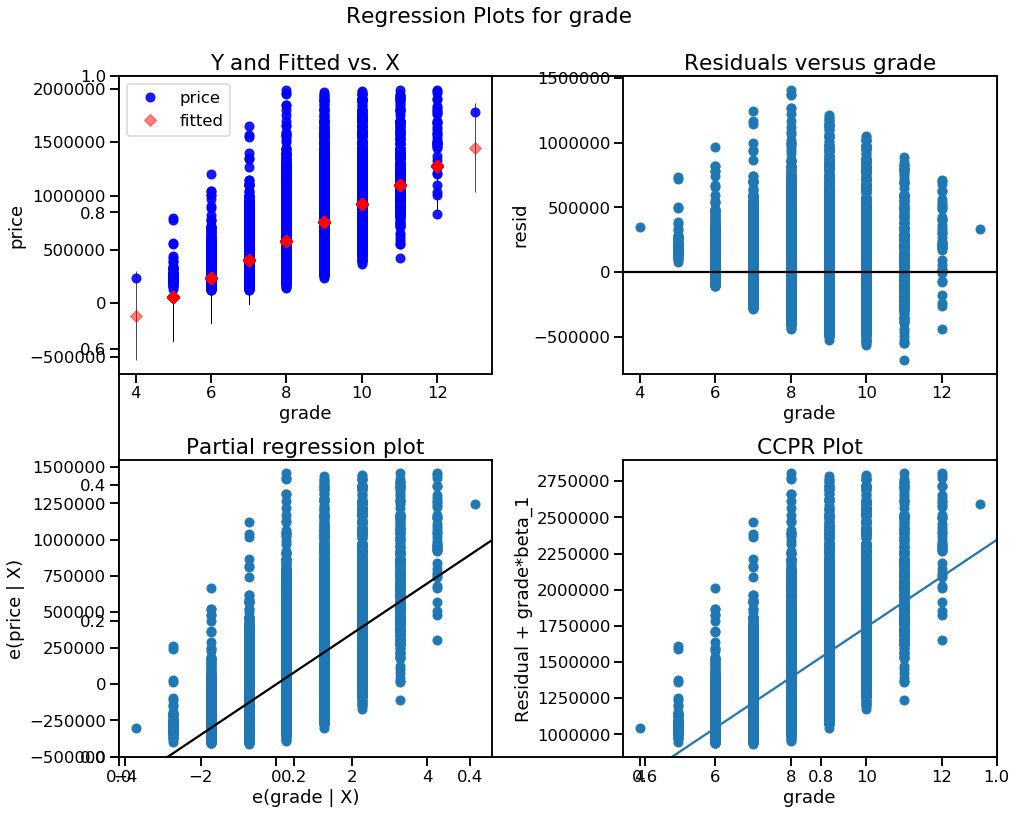

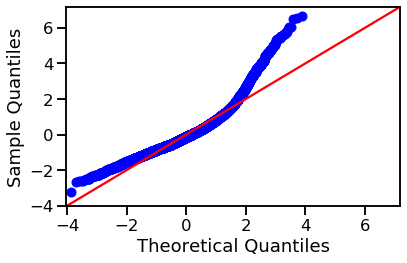

SQFT_ABOVE SQFT_ABOVE SQFT_ABOVE SQFT_ABOVE SQFT_ABOVE 
Housing Data - Regression Analysis and Diagnostics for Price~sqft_above
                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.297
Model:                            OLS   Adj. R-squared:                  0.297
Method:                 Least Squares   F-statistic:                     7998.
Date:                Mon, 20 Jul 2020   Prob (F-statistic):               0.00
Time:                        14:56:08   Log-Likelihood:            -2.6084e+05
No. Observations:               18912   AIC:                         5.217e+05
Df Residuals:                   18910   BIC:                         5.217e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
---

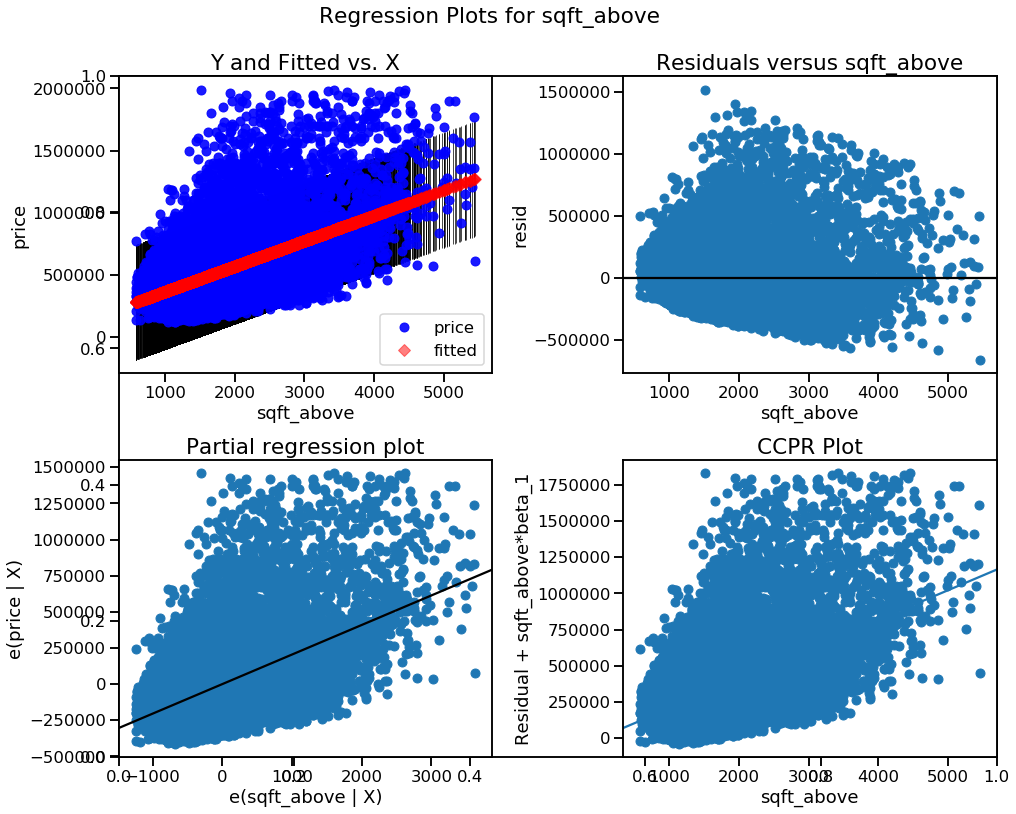

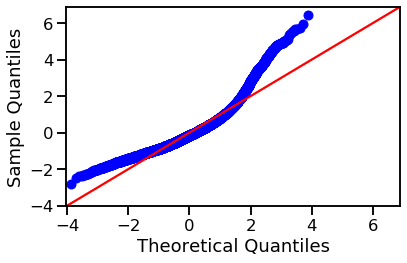

SQFT_BASEMENT SQFT_BASEMENT SQFT_BASEMENT SQFT_BASEMENT SQFT_BASEMENT 
Housing Data - Regression Analysis and Diagnostics for Price~sqft_basement
                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.060
Model:                            OLS   Adj. R-squared:                  0.060
Method:                 Least Squares   F-statistic:                     1204.
Date:                Mon, 20 Jul 2020   Prob (F-statistic):          8.51e-256
Time:                        14:56:11   Log-Likelihood:            -2.6359e+05
No. Observations:               18912   AIC:                         5.272e+05
Df Residuals:                   18910   BIC:                         5.272e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [

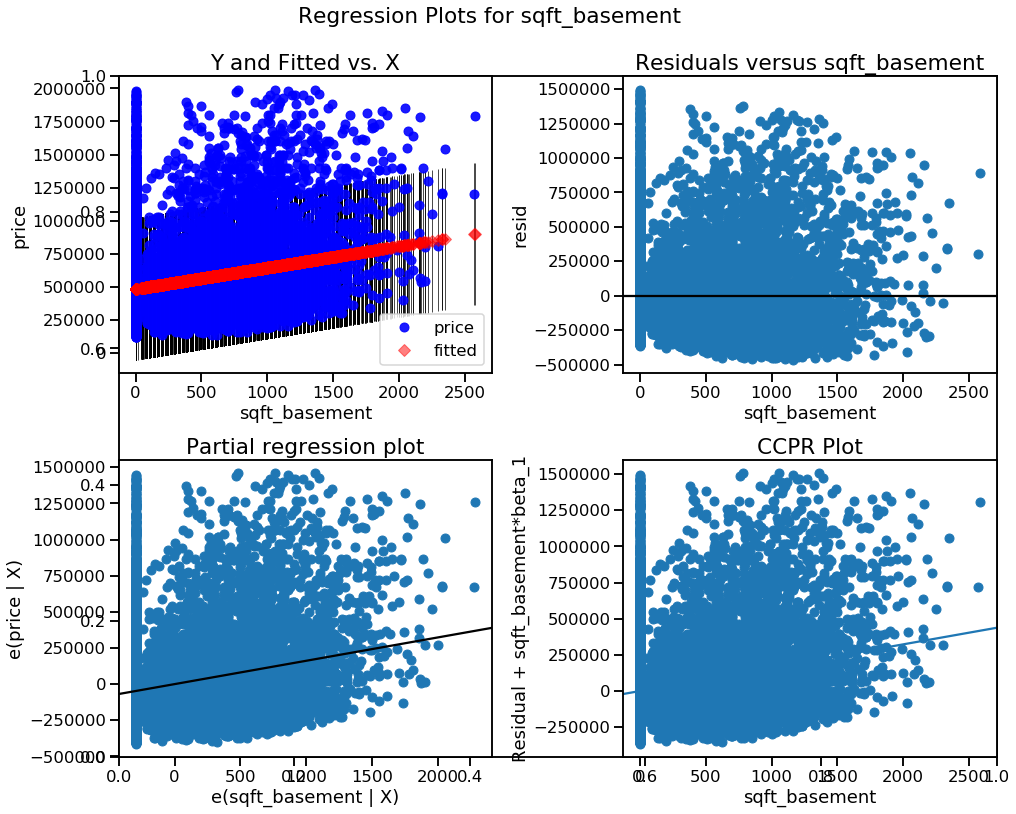

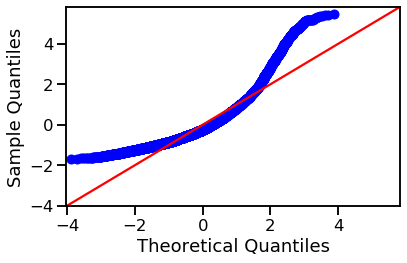

YR_BUILT YR_BUILT YR_BUILT YR_BUILT YR_BUILT 
Housing Data - Regression Analysis and Diagnostics for Price~yr_built
                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                  0.000
Method:                 Least Squares   F-statistic:                     2.577
Date:                Mon, 20 Jul 2020   Prob (F-statistic):              0.108
Time:                        14:56:16   Log-Likelihood:            -2.6417e+05
No. Observations:               18912   AIC:                         5.283e+05
Df Residuals:                   18910   BIC:                         5.284e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
---------------

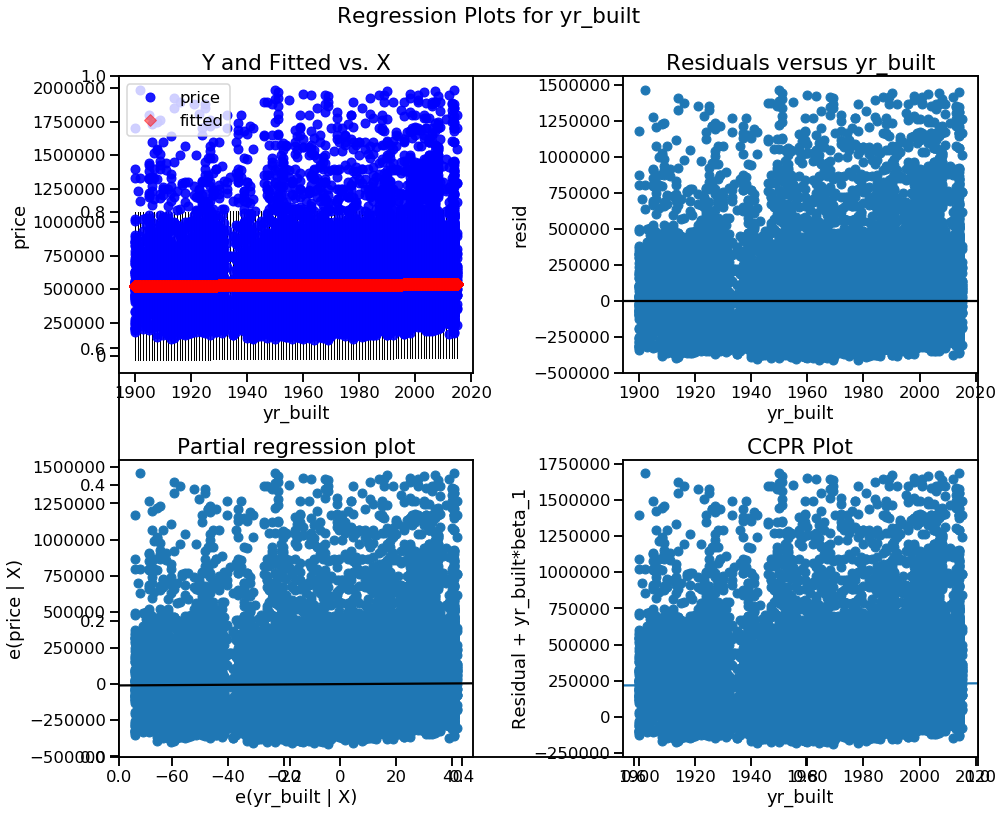

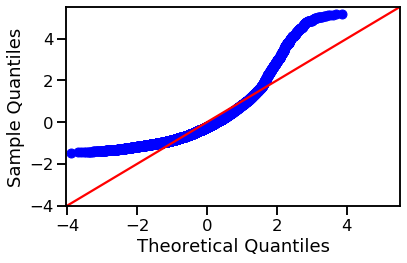

YR_RENOVATED YR_RENOVATED YR_RENOVATED YR_RENOVATED YR_RENOVATED 
Housing Data - Regression Analysis and Diagnostics for Price~yr_renovated
                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.003
Model:                            OLS   Adj. R-squared:                  0.003
Method:                 Least Squares   F-statistic:                     53.86
Date:                Mon, 20 Jul 2020   Prob (F-statistic):           2.24e-13
Time:                        14:56:20   Log-Likelihood:            -2.6414e+05
No. Observations:               18912   AIC:                         5.283e+05
Df Residuals:                   18910   BIC:                         5.283e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025  

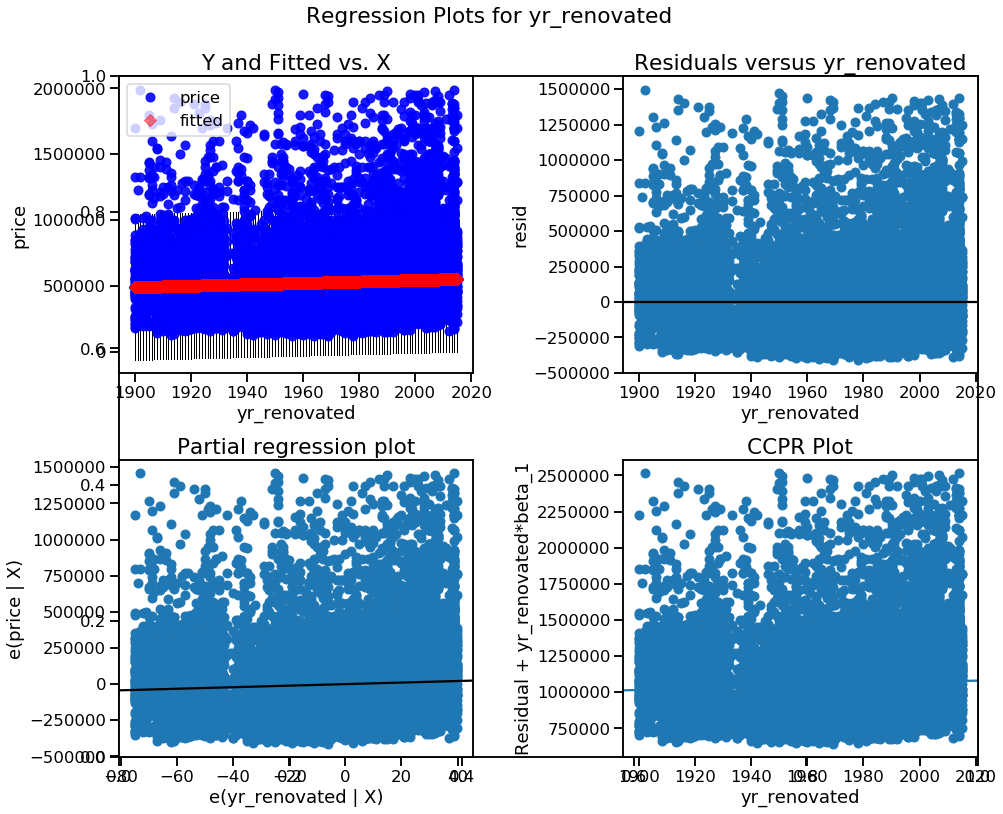

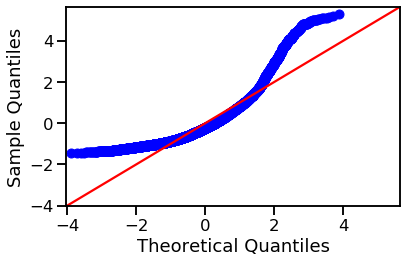

SQFT_LIVING15 SQFT_LIVING15 SQFT_LIVING15 SQFT_LIVING15 SQFT_LIVING15 
Housing Data - Regression Analysis and Diagnostics for Price~sqft_living15
                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.332
Model:                            OLS   Adj. R-squared:                  0.332
Method:                 Least Squares   F-statistic:                     9388.
Date:                Mon, 20 Jul 2020   Prob (F-statistic):               0.00
Time:                        14:56:23   Log-Likelihood:            -2.6036e+05
No. Observations:               18912   AIC:                         5.207e+05
Df Residuals:                   18910   BIC:                         5.207e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [

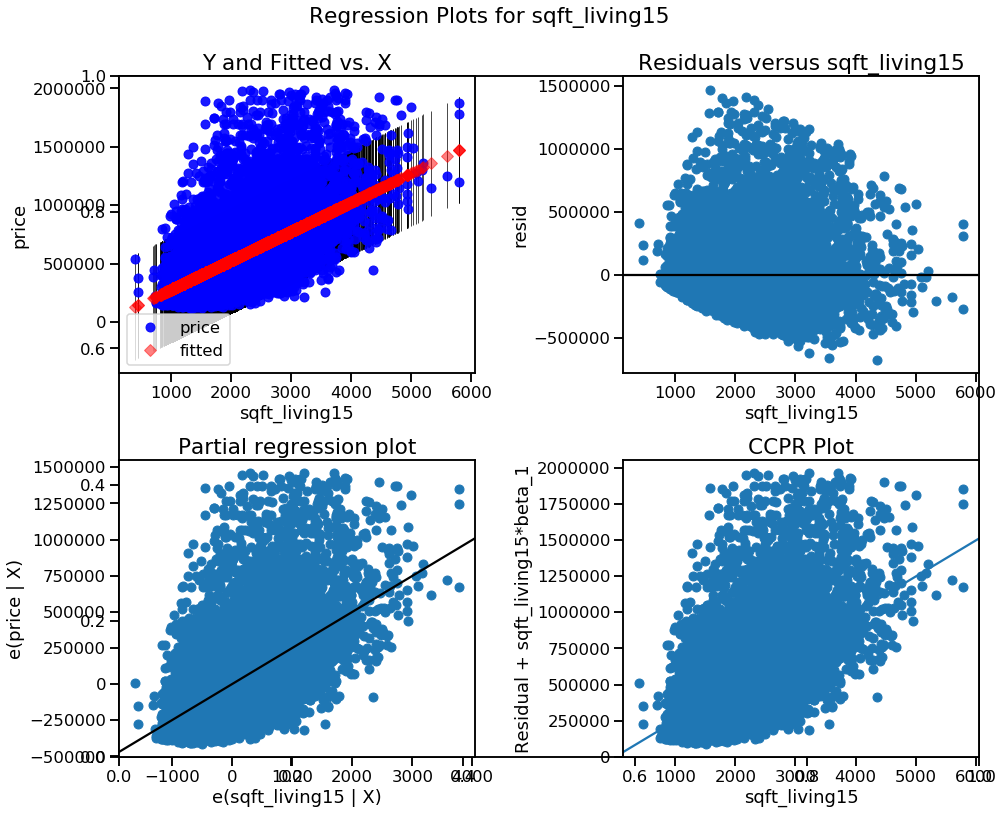

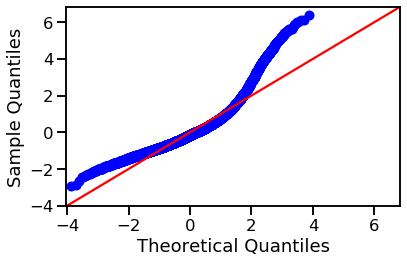

SQFT_LOT15 SQFT_LOT15 SQFT_LOT15 SQFT_LOT15 SQFT_LOT15 
Housing Data - Regression Analysis and Diagnostics for Price~sqft_lot15
                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.006
Model:                            OLS   Adj. R-squared:                  0.006
Method:                 Least Squares   F-statistic:                     106.6
Date:                Mon, 20 Jul 2020   Prob (F-statistic):           6.33e-25
Time:                        14:56:25   Log-Likelihood:            -2.6412e+05
No. Observations:               18912   AIC:                         5.282e+05
Df Residuals:                   18910   BIC:                         5.283e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
---

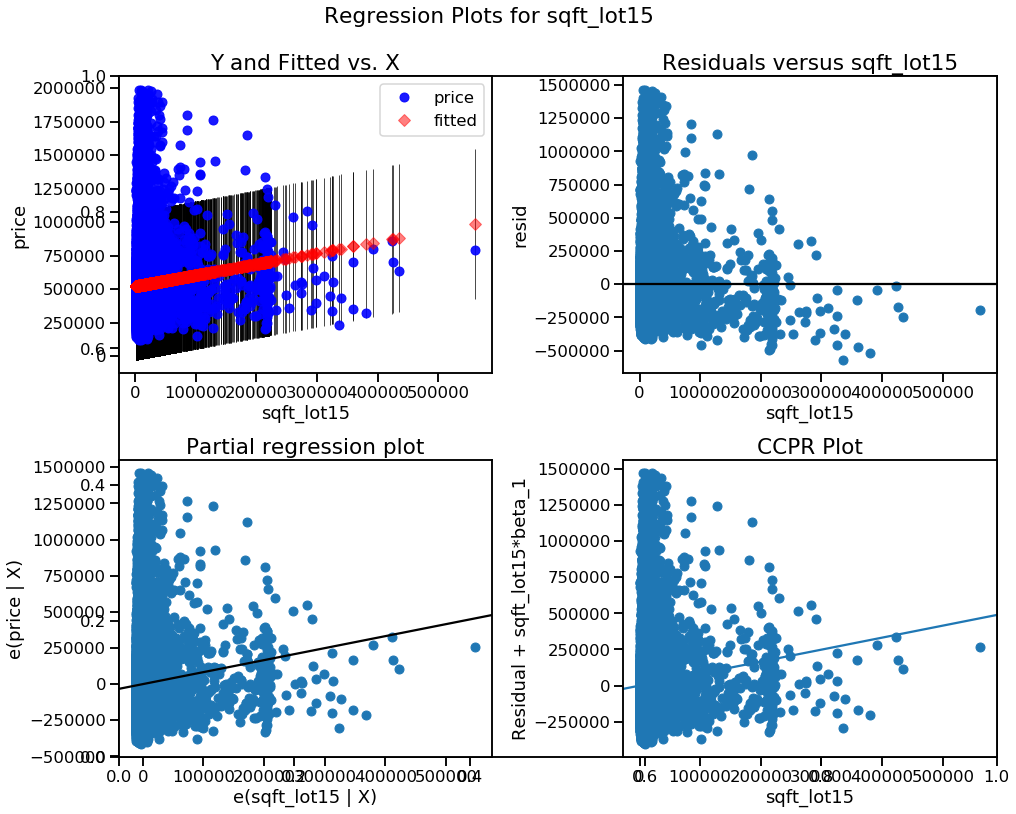

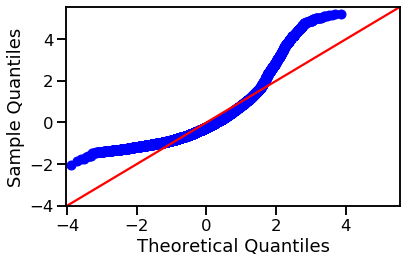

MONTH MONTH MONTH MONTH MONTH 
Housing Data - Regression Analysis and Diagnostics for Price~month
                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                  0.000
Method:                 Least Squares   F-statistic:                     3.039
Date:                Mon, 20 Jul 2020   Prob (F-statistic):             0.0813
Time:                        14:56:34   Log-Likelihood:            -2.6417e+05
No. Observations:               18912   AIC:                         5.283e+05
Df Residuals:                   18910   BIC:                         5.284e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------

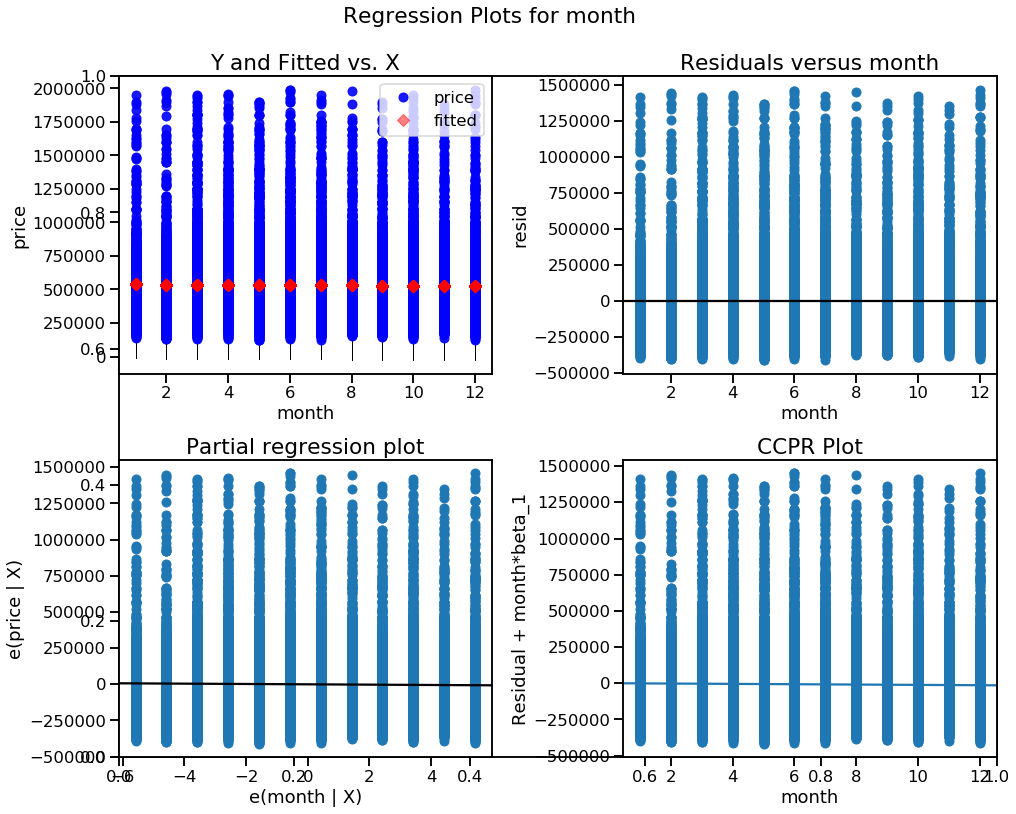

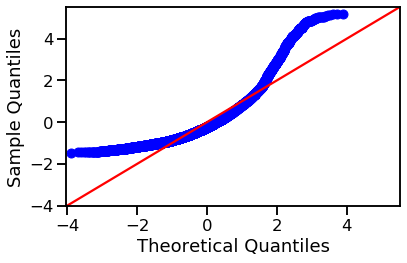

HAS_BASEMENT HAS_BASEMENT HAS_BASEMENT HAS_BASEMENT HAS_BASEMENT 
Housing Data - Regression Analysis and Diagnostics for Price~has_basement
                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.020
Model:                            OLS   Adj. R-squared:                  0.020
Method:                 Least Squares   F-statistic:                     386.1
Date:                Mon, 20 Jul 2020   Prob (F-statistic):           4.03e-85
Time:                        14:56:37   Log-Likelihood:            -2.6398e+05
No. Observations:               18912   AIC:                         5.280e+05
Df Residuals:                   18910   BIC:                         5.280e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025  

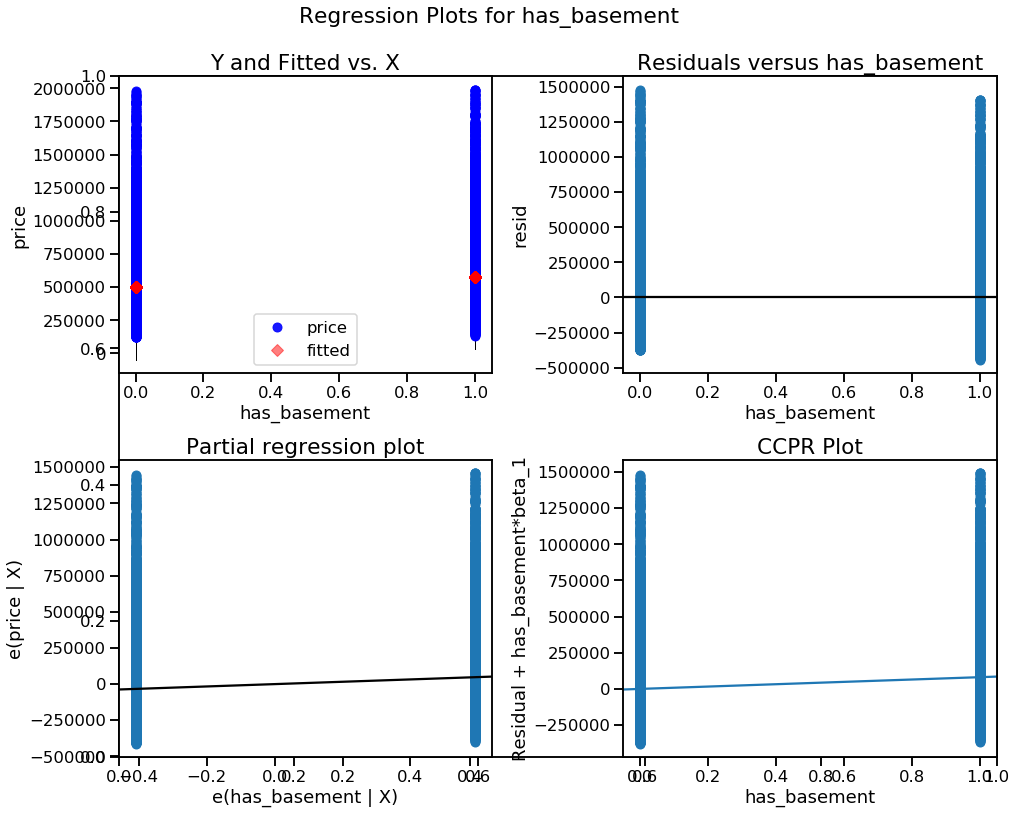

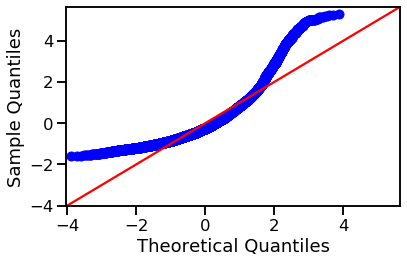

SCHOOL_SCORE SCHOOL_SCORE SCHOOL_SCORE SCHOOL_SCORE SCHOOL_SCORE 
Housing Data - Regression Analysis and Diagnostics for Price~school_score
                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.217
Model:                            OLS   Adj. R-squared:                  0.217
Method:                 Least Squares   F-statistic:                     5227.
Date:                Mon, 20 Jul 2020   Prob (F-statistic):               0.00
Time:                        14:56:41   Log-Likelihood:            -2.6186e+05
No. Observations:               18912   AIC:                         5.237e+05
Df Residuals:                   18910   BIC:                         5.237e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025  

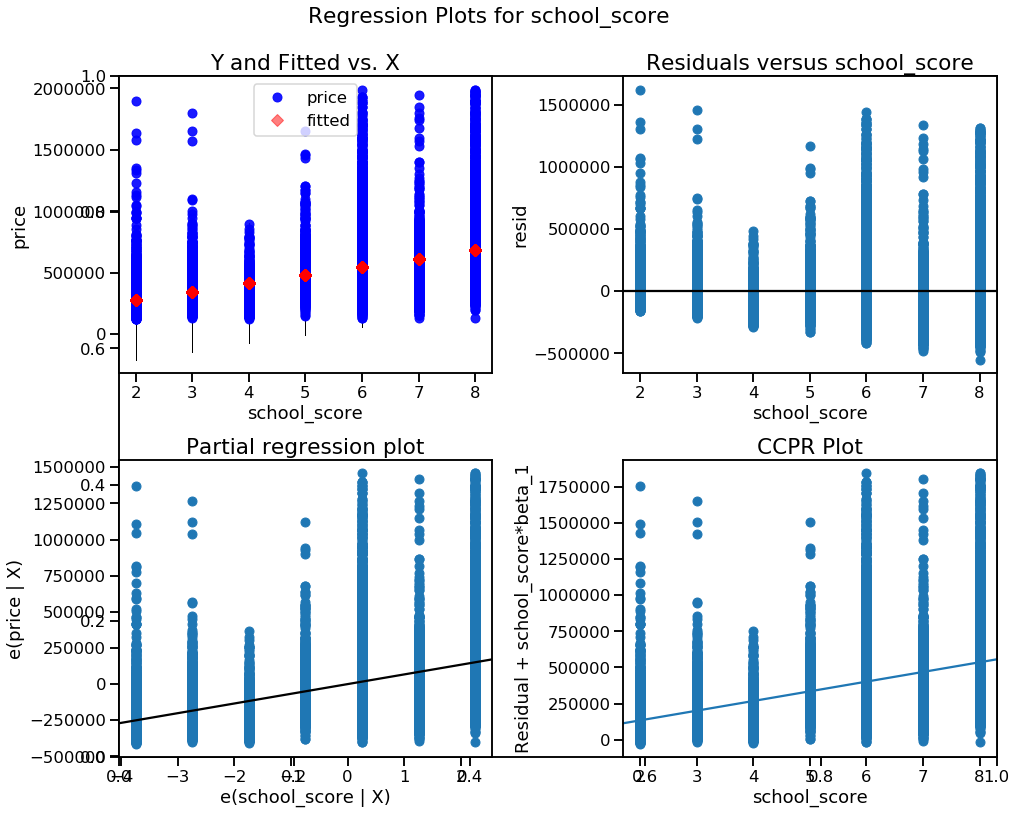

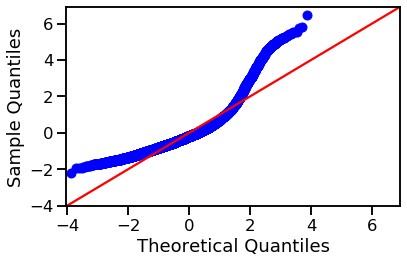

NEAREST_WATER NEAREST_WATER NEAREST_WATER NEAREST_WATER NEAREST_WATER 
Housing Data - Regression Analysis and Diagnostics for Price~nearest_water
                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.062
Model:                            OLS   Adj. R-squared:                  0.062
Method:                 Least Squares   F-statistic:                     1243.
Date:                Mon, 20 Jul 2020   Prob (F-statistic):          1.02e-263
Time:                        14:56:44   Log-Likelihood:            -2.6357e+05
No. Observations:               18912   AIC:                         5.271e+05
Df Residuals:                   18910   BIC:                         5.272e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [

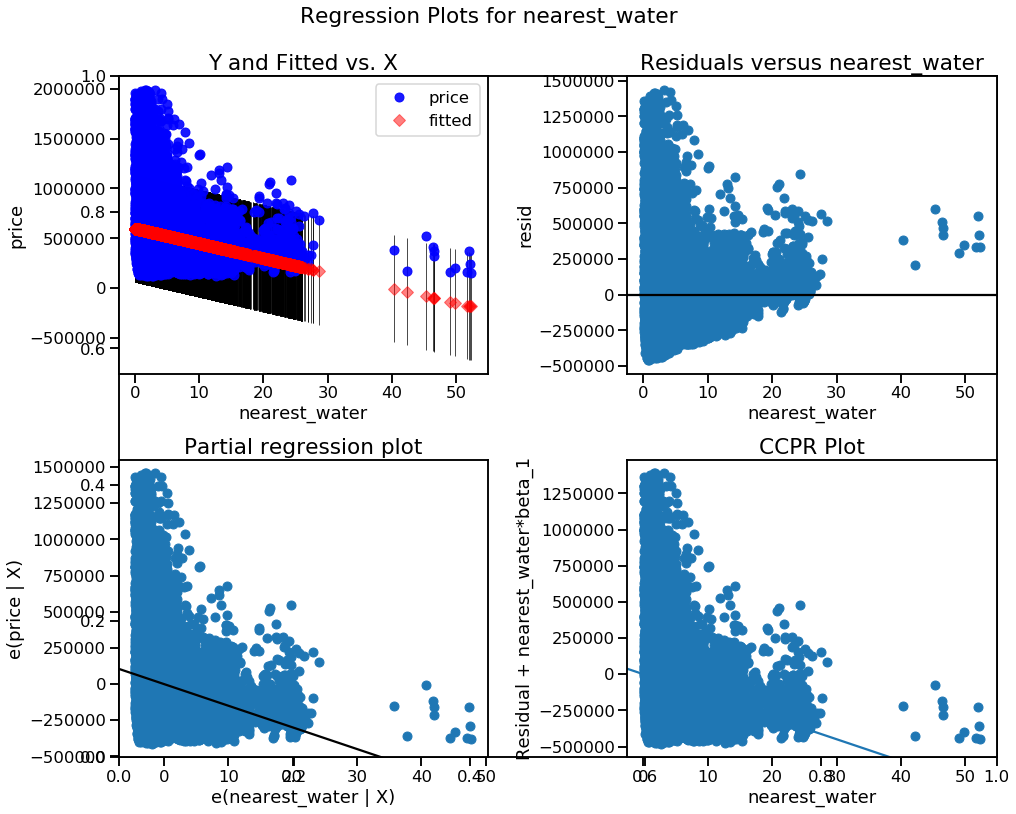

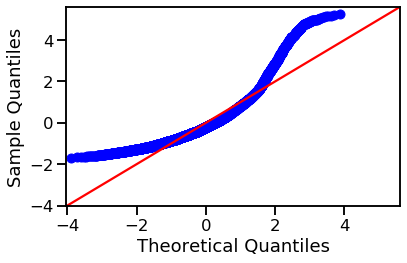

DOWNTOWN_DIST DOWNTOWN_DIST DOWNTOWN_DIST DOWNTOWN_DIST DOWNTOWN_DIST 
Housing Data - Regression Analysis and Diagnostics for Price~downtown_dist
                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.057
Model:                            OLS   Adj. R-squared:                  0.057
Method:                 Least Squares   F-statistic:                     1141.
Date:                Mon, 20 Jul 2020   Prob (F-statistic):          7.48e-243
Time:                        14:56:47   Log-Likelihood:            -2.6362e+05
No. Observations:               18912   AIC:                         5.272e+05
Df Residuals:                   18910   BIC:                         5.273e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [

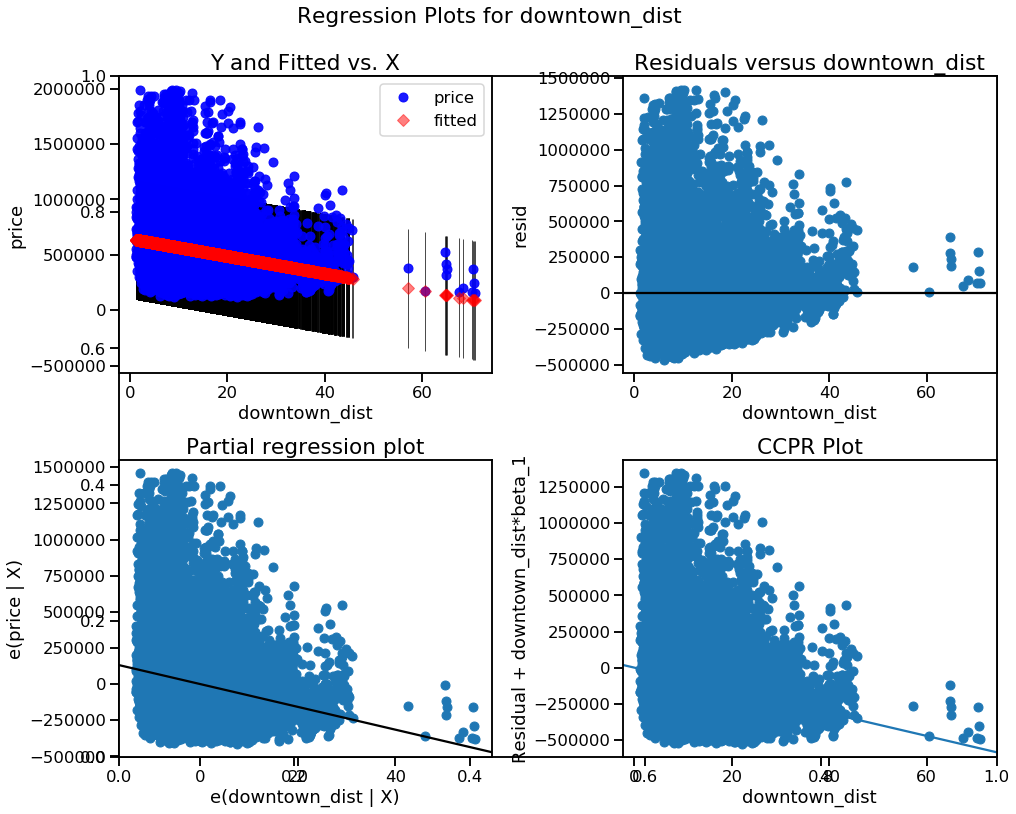

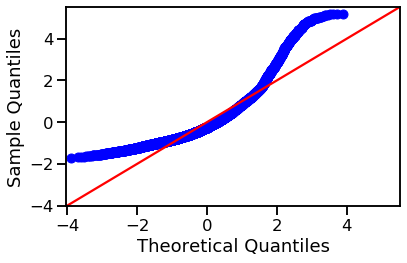

NEAREST_BUCKS NEAREST_BUCKS NEAREST_BUCKS NEAREST_BUCKS NEAREST_BUCKS 
Housing Data - Regression Analysis and Diagnostics for Price~nearest_bucks
                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.002
Model:                            OLS   Adj. R-squared:                  0.001
Method:                 Least Squares   F-statistic:                     29.35
Date:                Mon, 20 Jul 2020   Prob (F-statistic):           6.12e-08
Time:                        14:56:49   Log-Likelihood:            -2.6416e+05
No. Observations:               18912   AIC:                         5.283e+05
Df Residuals:                   18910   BIC:                         5.283e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [

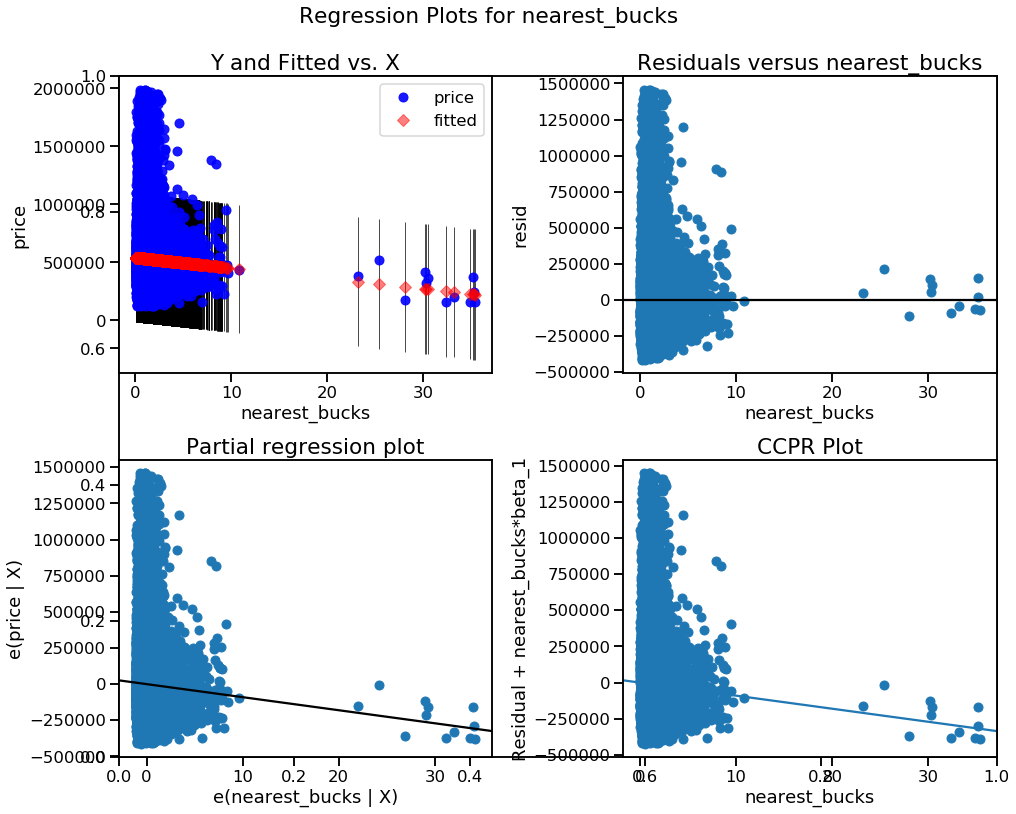

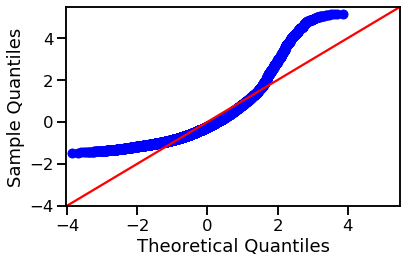

VIEWS_NEARBY VIEWS_NEARBY VIEWS_NEARBY VIEWS_NEARBY VIEWS_NEARBY 
Housing Data - Regression Analysis and Diagnostics for Price~views_nearby
                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.111
Model:                            OLS   Adj. R-squared:                  0.111
Method:                 Least Squares   F-statistic:                     2371.
Date:                Mon, 20 Jul 2020   Prob (F-statistic):               0.00
Time:                        14:56:52   Log-Likelihood:            -2.6305e+05
No. Observations:               18912   AIC:                         5.261e+05
Df Residuals:                   18910   BIC:                         5.261e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025  

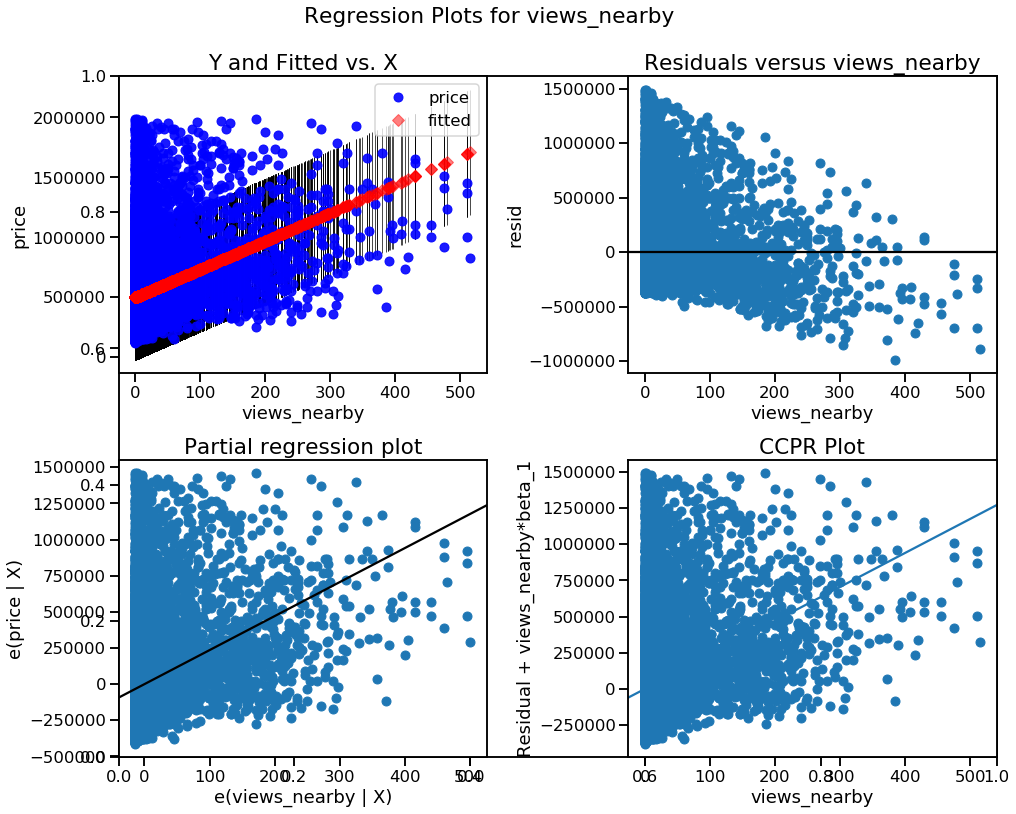

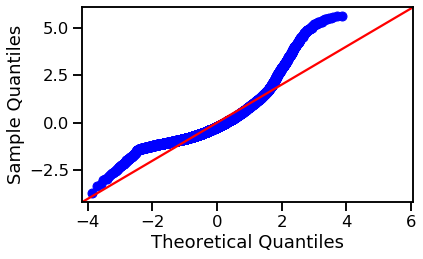

QUARTER QUARTER QUARTER QUARTER QUARTER 
Housing Data - Regression Analysis and Diagnostics for Price~quarter
                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                  0.000
Method:                 Least Squares   F-statistic:                     2.818
Date:                Mon, 20 Jul 2020   Prob (F-statistic):             0.0932
Time:                        14:56:54   Log-Likelihood:            -2.6417e+05
No. Observations:               18912   AIC:                         5.283e+05
Df Residuals:                   18910   BIC:                         5.284e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
---------------------

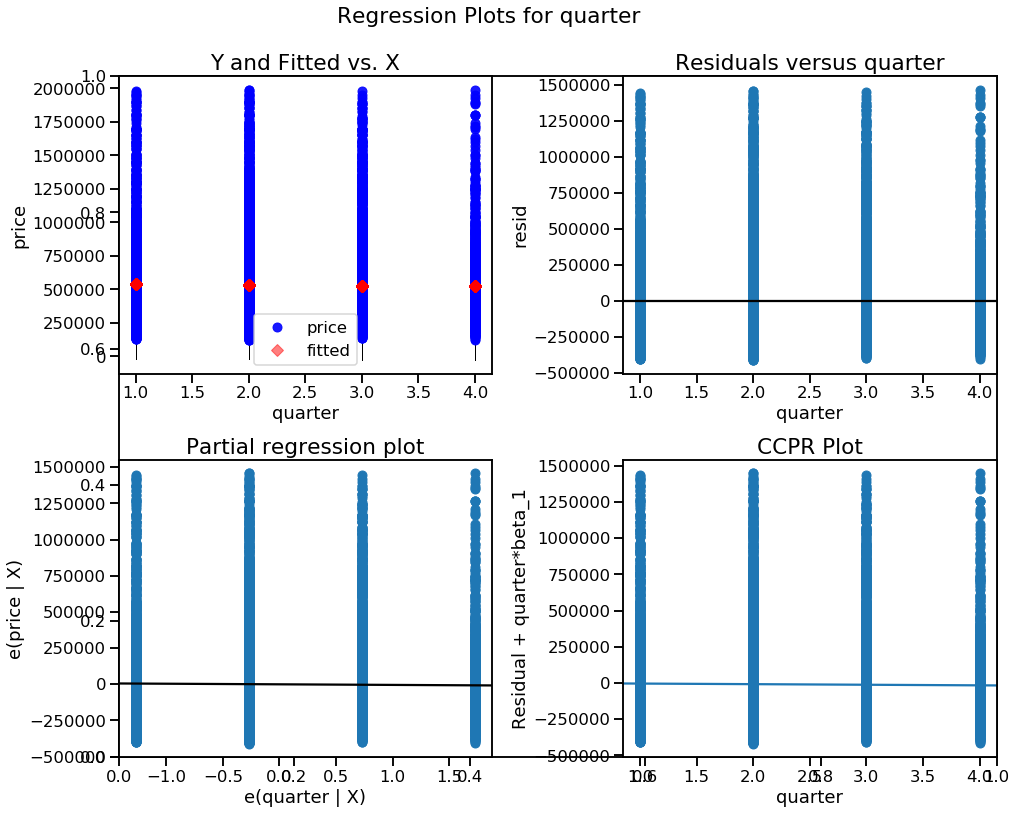

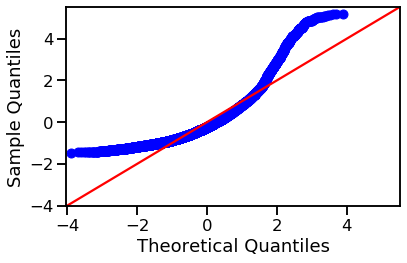

ind_var  r_squared      intercept          slope        p-value  \
8           grade   0.441002 -815046.247122  174247.269074   0.000000e+00   
2     sqft_living   0.431292   30336.504912     236.435277   0.000000e+00   
13  sqft_living15   0.331751   28367.900070     249.511139   0.000000e+00   
9      sqft_above   0.297229  158658.724623     204.513962   0.000000e+00   
17   school_score   0.216558  146683.377979   66994.689171   0.000000e+00   
1       bathrooms   0.215066  117952.300262  191136.691363   0.000000e+00   
6            view   0.112312  503447.119685  129552.322996   0.000000e+00   
21   views_nearby   0.111417  498449.059563    2349.898095   0.000000e+00   
0        bedrooms   0.073524  188753.813411  100451.444751   0.000000e+00   
18  nearest_water   0.061665  599804.703802  -14974.823376  1.024639e-263   
10  sqft_basement   0.059855  483734.029492     161.422241  8.509520e-256   
4          floors   0.057876  340989.143627  125364.816231  3.759813e-247   
19  downtown_dist   0.056890  645335.320149   -7870.729925  7.478356e-243   
5      waterfront   0.020895  528945.307190  627979.067810   7.820362e-89   
16   has_basement   0.020012  498391.748232   81114.197655   4.032321e-85   
3        sqft_lot   0.006746  522838.212880       0.586473   1.120524e-29   
14     sqft_lot15   0.005606  521085.888594       0.829779   6.329564e-25   
12   yr_renovated   0.002840 -524993.964932     534.956834   2.239438e-13   
20  nearest_bucks   0.001550  542217.716316   -9027.943280   6.117176e-08   
7       condition   0.000906  485704.875375   13424.500787   3.459530e-05   
15          month   0.000161  539170.439720   -1150.693610   8.127963e-02   
22        quarter   0.000149  540875.114926   -4082.645401   9.323076e-02   
11       yr_built   0.000136  304878.543155     114.899540   1.084575e-01   

    normality (JB)  
8     17175.465743  
2     13649.730138  
13    22820.931948  
9     16924.083580  
17    31675.855224  
1     16166.796777  
6     19671.731075  
21    23192.348755  
0     20206.112379  
18    20688.729304  
10    21418.990683  
4     22135.009448  
19    20753.422167  
5     21068.008843  
16    22164.670240  
3     22499.547685  
14    22379.278287  
12    21982.262090  
20    22172.052388  
7     22141.775167  
15    22158.754617  
22    22153.741171  
11    22156.290552

In [117]:
# Lets look at some regressions for all of my chosen columns

# import libraries
import statsmodels.api as sm
import statsmodels.formula.api as smf
import scipy.stats as stats
import statsmodels.stats.api as sms

# I don't need to see regression analysis for all of my variables
drops = ['date', 
         'longlat', 
         'points', 
         'school_district', 
         'lat', 
         'long',
         'zipcode',
         'id',
         'price'
        ]

results = []
for idx, column in enumerate(kc2.drop(columns=drops, axis=1).columns):
    
    print((column.upper() + " ") * 5)
    print (f"Housing Data - Regression Analysis and Diagnostics for Price~{column}")
    
    f = f'price~{column}'  # create my model formula
    model = smf.ols(formula=f, data=kc2).fit()  # fit the model
    print(model.summary())
    
    fig, axes = plt.subplots(figsize=(15,12))
    fig = sm.graphics.plot_regress_exog(model, column, fig=fig)
    fig = sm.graphics.qqplot(model.resid, dist=stats.norm, line='45', fit=True)
    fig.tight_layout()
    plt.show()
    
    results.append([column, model.rsquared, model.params[0], model.params[1], model.pvalues[1], sms.jarque_bera(model.resid)[0]])

result_df = pd.DataFrame(results, columns=['ind_var', 'r_squared', 'intercept', 'slope', 'p-value', 'normality (JB)' ])
result_df.sort_values(by='r_squared', ascending=False)

In [119]:
result_df[['ind_var', 'r_squared', 'p-value']]

ind_var  r_squared        p-value
0        bedrooms   0.073524   0.000000e+00
1       bathrooms   0.215066   0.000000e+00
2     sqft_living   0.431292   0.000000e+00
3        sqft_lot   0.006746   1.120524e-29
4          floors   0.057876  3.759813e-247
5      waterfront   0.020895   7.820362e-89
6            view   0.112312   0.000000e+00
7       condition   0.000906   3.459530e-05
8           grade   0.441002   0.000000e+00
9      sqft_above   0.297229   0.000000e+00
10  sqft_basement   0.059855  8.509520e-256
11       yr_built   0.000136   1.084575e-01
12   yr_renovated   0.002840   2.239438e-13
13  sqft_living15   0.331751   0.000000e+00
14     sqft_lot15   0.005606   6.329564e-25
15          month   0.000161   8.127963e-02
16   has_basement   0.020012   4.032321e-85
17   school_score   0.216558   0.000000e+00
18  nearest_water   0.061665  1.024639e-263
19  downtown_dist   0.056890  7.478356e-243
20  nearest_bucks   0.001550   6.117176e-08
21   views_nearby   0.111417   0.000000e+00
22        quarter   0.000149   9.323076e-02

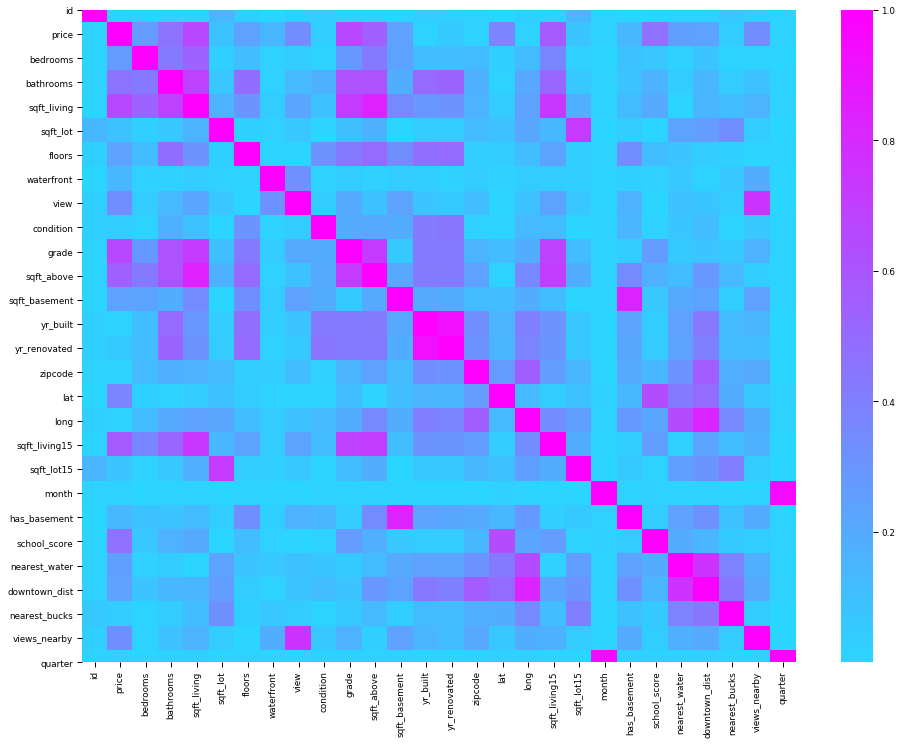

In [65]:


kc_features = kc2.copy()
plt.figure(figsize = (16,12))
sns.heatmap(abs(kc_features.corr()), center=0.4, cmap = "cool");




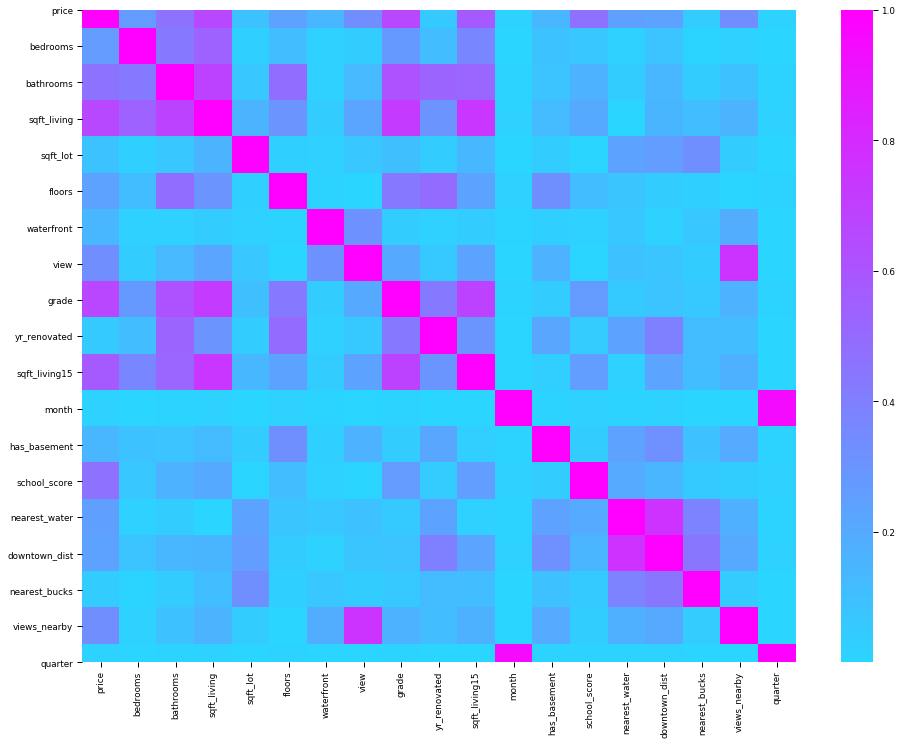

In [66]:
kc_features = kc2.drop(['sqft_above', 'sqft_lot15', 'sqft_lot15', 'yr_built', 'id', 'lat', 'long'
                    , 'sqft_basement', 'zipcode', 'condition'], axis=1)
plt.figure(figsize = (16,12))
sns.heatmap(abs(kc_features.corr()), center=0.4, cmap = "cool");


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7ff8ffd3cf98>,
      dtype=object)

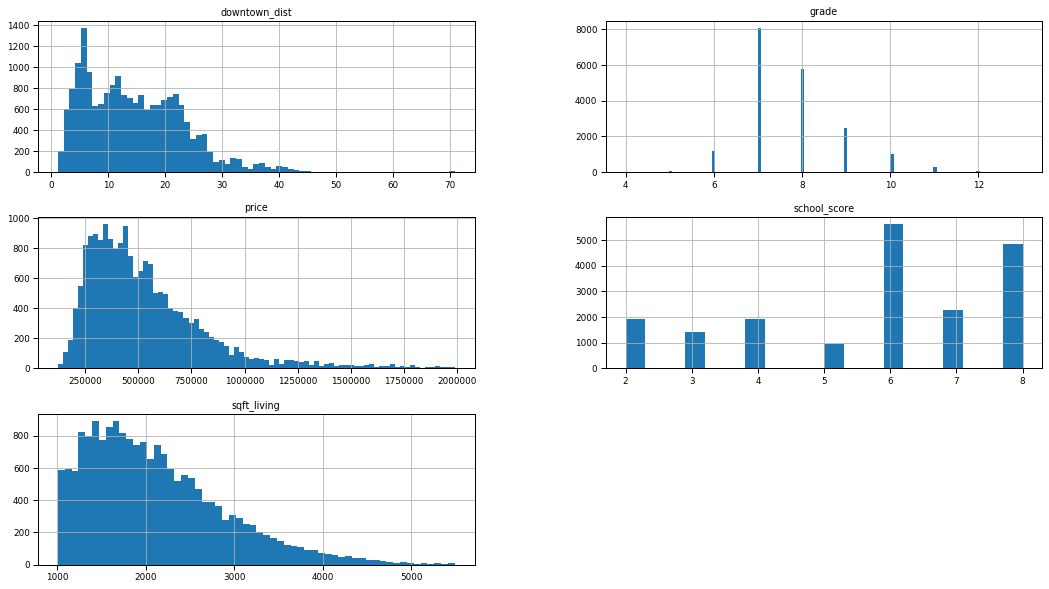

In [67]:
# CHoose the features to use

continuous = ['price', 
              'grade', 
              #'bedrooms',   # bed and bath OR sqft_living
              #'bathrooms', 
              'sqft_living',
              'downtown_dist',  # downtown_dist OR nearest_water
              #'nearest_water',
              'school_score'
             ]
categoricals = ['view']

kc_cont = kc_features[continuous]
kc_cont.hist(figsize=[18,10], bins='auto')


## Log and normalize features as needed

In [68]:
# Start by not doing any normalization
kc_cont_log = kc_cont.copy()

# log_features = ['downtown_dist']


# # divide by zero if I log zero
# kc_cont_log.loc['downtown_dist'] = kc_cont_log['downtown_dist'] + 0.05

# for col in log_features:
#     kc_cont_log[col] = np.log(kc_cont_log[col])
#     kc_cont_log.rename(columns={col: col + "_log"}, inplace=True)


# kc_cont_log.head()

# kc_cont_log.hist(figsize=[18,10], bins='auto')
# print(kc_cont.head(), kc_cont_log.head())

In [69]:
# normalize (subract mean and divide by std)
def normalize(feature):
    # returns a normalized standard score between 
    return (feature - feature.mean()) / feature.std()


#kc_cont_log.downtown_dist_log = kc_cont_log.apply(normalize)['downtown_dist_log']
# kc_log_norm.hist(figsize=[18,10], bins='auto')




In [70]:
from functools import reduce

kc2[categoricals].nunique()


# Thought this would work, but failed.  Prefix len problem
# dummies = pd.get_dummies(kc[categorical[0]], prefix=categorical[0], drop_first=True)
# dummies


def add_dummies(df, cats):
    dummies = []
    for cat in cats:
        dummy = pd.get_dummies(df[cat], prefix=cat, drop_first=True)
        dummies.append(dummy)

    dummies_df = pd.concat(dummies, axis=1, sort=False)                   
    return dummies_df

                       
# one hot encode categoricals
kc_ohe = add_dummies(kc2, categoricals)
                       
preprocessed = pd.concat([kc_cont_log, kc_ohe], axis=1)
#preprocessed = kc_cont.copy() # FOR TROUBLESHOOTING

preprocessed.describe()
preprocessed.dropna(inplace=True)
preprocessed.isna().sum()


price            0
grade            0
sqft_living      0
downtown_dist    0
school_score     0
view_1.0         0
view_2.0         0
view_3.0         0
view_4.0         0
dtype: int64

In [71]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

regression = LinearRegression()

X = preprocessed.drop('price', axis=1)
y = preprocessed['price']

crossvalidation = KFold(n_splits=5, shuffle=True, random_state=1)
baseline = np.mean(cross_val_score(regression, X, y, scoring='r2', cv=crossvalidation))


#preprocessed.columns 
baseline


0.6990395260831109

In [72]:
regression.fit(X, y)
coefficients = dict(zip(X.columns,list(regression.coef_)))
coefficients


{'grade': 78037.90833279135,
 'sqft_living': 140.94600028381723,
 'downtown_dist': -8845.88207478379,
 'school_score': 38116.39475887597,
 'view_1.0': 99472.80846835602,
 'view_2.0': 93477.37469634533,
 'view_3.0': 170133.09222368602,
 'view_4.0': 344191.5901786747}

In [73]:
# !pip install geopy

In [74]:
# FEATURE SELECTION


import statsmodels.api as sm

def stepwise_selection(X, y, 
                       initial_list=[], 
                       threshold_in=0.01, 
                       threshold_out = 0.05, 
                       verbose=True):
    """ Perform a forward-backward feature selection 
    based on p-value from statsmodels.api.OLS
    Arguments:
        X - pandas.DataFrame with candidate features
        y - list-like with the target
        initial_list - list of features to start with (column names of X)
        threshold_in - include a feature if its p-value < threshold_in
        threshold_out - exclude a feature if its p-value > threshold_out
        verbose - whether to print the sequence of inclusions and exclusions
    Returns: list of selected features 
    Always set threshold_in < threshold_out to avoid infinite looping.
    See https://en.wikipedia.org/wiki/Stepwise_regression for the details
    """
    included = list(initial_list)
    while True:
        changed=False
        # forward step
        excluded = list(set(X.columns)-set(included))
        new_pval = pd.Series(index=excluded)
        for new_column in excluded:
            model = sm.OLS(y, sm.add_constant(pd.DataFrame(X[included+[new_column]]))).fit()
            new_pval[new_column] = model.pvalues[new_column]
        best_pval = new_pval.min()
        if best_pval < threshold_in:
            best_feature = new_pval.idxmin()
            included.append(best_feature)
            changed=True
            if verbose:
                print('Add  {:30} with p-value {:.6}'.format(best_feature, best_pval))

        # backward step
        model = sm.OLS(y, sm.add_constant(pd.DataFrame(X[included]))).fit()
        # use all coefs except intercept
        pvalues = model.pvalues.iloc[1:]
        worst_pval = pvalues.max() # null if pvalues is empty
        if worst_pval > threshold_out:
            changed=True
            worst_feature = pvalues.argmax()
            included.remove(worst_feature)
            if verbose:
                print('Drop {:30} with p-value {:.6}'.format(worst_feature, worst_pval))
        if not changed:
            break
    return included

In [75]:
keepers = stepwise_selection(X, y)

/Users/aaronlee/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


Add  sqft_living                    with p-value 0.0
Add  grade                          with p-value 0.0
Add  downtown_dist                  with p-value 0.0
Add  school_score                   with p-value 0.0
Add  view_4.0                       with p-value 1.90008e-190
Add  view_3.0                       with p-value 1.51403e-95
Add  view_2.0                       with p-value 8.87723e-59
Add  view_1.0                       with p-value 1.85339e-27


In [76]:

yhat = regression.predict(X)
sum_squares_residual = np.sum((y - yhat)**2)
sum_squares_total = np.sum((y - np.mean(y))**2)

r_squared = 1 - (float(sum_squares_residual)) / sum_squares_total
adj_r_squared = 1 - (1 - r_squared)*(len(y) - 1) / (len(y) - X.shape[1] - 1)

print('r_squared: {}\nadj_r_squared: {}'.format(r_squared, adj_r_squared))


r_squared: 0.6995729372584697
adj_r_squared: 0.6994457925458879


In [77]:
# Drop the columns from stepwise feature elimination
X = X[keepers]
X.columns

Index(['sqft_living', 'grade', 'downtown_dist', 'school_score', 'view_4.0',
       'view_3.0', 'view_2.0', 'view_1.0'],
      dtype='object')

In [78]:
# Refit it and try again
regression.fit(X, y)


yhat = regression.predict(X)
sum_squares_residual = np.sum((y - yhat)**2)
sum_squares_total = np.sum((y - np.mean(y))**2)

r_squared = 1 - (float(sum_squares_residual)) / sum_squares_total
adj_r_squared = 1 - (1 - r_squared)*(len(y) - 1) / (len(y) - X.shape[1] - 1)

print('r_squared: {}\nadj_r_squared: {}'.format(r_squared, adj_r_squared))

r_squared: 0.6995729372584698
adj_r_squared: 0.6994457925458881


In [79]:
import geopy
import os


with open(os.path.expanduser('~/.secret/smarty_streets.json')) as f:
  keys = json.load(f)



address = '16613 SE 16th St, Bellevue'


In [80]:
# Make an intereactive predictor

# import ipywidgets as widgets
# from ipywidgets import interact, interact_manual

# def predict_price(coefs, column1_value, column2_value):
#     display(df.loc[(df['views'] < column1_value) & 
#                     (df['reads'] < column2_value), 
#                    ['title', 'read_time', 'tags', 'views', 'reads']])
        
# column1_value=widgets.IntText(value=100, label='First')
# column2_value=widgets.IntSlider(value=100, label='Second')

# linked = widgets.jslink((column1_value, 'value'),
#                         (column2_value, 'value'))

# less_than = interact(show_less_than, column1_value=column1_value,
#                  column2_value=column2_value)

In [81]:
X.columns

Index(['sqft_living', 'grade', 'downtown_dist', 'school_score', 'view_4.0',
       'view_3.0', 'view_2.0', 'view_1.0'],
      dtype='object')

In [82]:
X = preprocessed[keepers]
regression.fit(X, y)
coefficients = list(zip(keepers, regression.coef_))
coefficients

[('sqft_living', 140.94600028379642),
 ('grade', 78037.90833279114),
 ('downtown_dist', -8845.882074783778),
 ('school_score', 38116.39475887594),
 ('view_4.0', 344191.5901786746),
 ('view_3.0', 170133.09222368588),
 ('view_2.0', 93477.37469634558),
 ('view_1.0', 99472.8084683562)]

# Model Validation

In [88]:
# MODEL VALIDATION
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=377)
print(len(X_train), len(X_test), len(y_train), len(y_test))


15129 3783 15129 3783


In [89]:
from sklearn.linear_model import LinearRegression
linreg = LinearRegression()
linreg.fit(X_train, y_train)

y_hat_train = linreg.predict(X_train)
y_hat_test = linreg.predict(X_test)

In [123]:
from sklearn.metrics import mean_squared_error

train_mse = mean_squared_error(y_train, y_hat_train)
test_mse = mean_squared_error(y_test, y_hat_test)
print('Train Mean Squarred Error:', train_mse)
print('Test Mean Squarred Error:', test_mse)
print(train_mse / test_mse)

print("RMSE:", np.sqrt(train_mse).round(-2), np.sqrt(test_mse).round(-2))

Train Mean Squarred Error: 23795705325.594067
Test Mean Squarred Error: 24272450149.82784
0.9803586032192488
RMSE: 154300.0 155800.0


In [91]:
for i in range(10):
    print(regression.predict(X.iloc[[i]])[0], y.iloc[i])


387458.37355697167 221900.0
594453.3116052985 538000.0
511718.68897129723 604000.0
512021.225935795 510000.0
1247103.4916837052 1230000.0
172884.65681193012 291850.0
337884.1057278004 229500.0
365413.7547793536 323000.0
837825.5487229278 662500.0
407888.7320652271 468000.0


In [92]:
cols = X.columns

In [93]:
# GEOCODING

from geopy import Nominatim
import time



In [94]:
# Find school district
import folium  # for plotting stuff later if needed.   Would be fun to do.
import json

# might not need all of these
from shapely.geometry import Polygon, Point, MultiPolygon, shape, GeometryCollection



my_shapes = "districts.geojson"  # geojson shape file for district boundaries

with open(my_shapes, 'r') as f:
    school_geo_data = json.load(f)


# make a list of the names of the school districts to appy later
dist_names = [x["properties"]["NAME"] for x in school_geo_data['features']]  # It worked!

# NOTE: buffer(0) is a trick for fixing scenarios where polygons have overlapping coordinates 
# We go through every item in the geojson features, and create mappable polygons from it
polygons = GeometryCollection([shape(feature["geometry"]).buffer(0) for feature in school_geo_data['features']])
polygons[0]


def make_point(long, lat):
    '''
    Returns a shapely Point object from a latlong location.

            Parameters:
                    latlong (list): iterable of len 2 [lat, long]

            Returns:
                    Point object
    '''
    # note that the point requires (long, lat) or (x, y) format
    return Point(long, lat)


def which_district(point, polygon_list, district_names):
    '''
    Returns the name from district_names list if point is in polygon from polygon_list
            
            Parameters:
                    point (Point object): Shapely Point
                    polygon_list (list): Shapely Shape objects (MultiPolygon)
                    district_names (list): list of school district names taken from geo_data

            Returns:
                    binary_sum (str): Binary string of the sum of a and b
    '''
    count = 0
    name = 'None'
    for i in range(len(polygon_list)):
        if polygon_list[i].contains(point):
            name = district_names[i]
            count += 1
    if count == 1: return name
    else: print("District ID failure at", point)


def find_closest_water(point, df):
    # return the minimum distance from a waterfront property in miles
    all_locs = df['points']
    closest = all_locs.apply(point.distance).min()
    miles = closest * 68.94  # convert degrees to miles
    miles += 0.1 # keeps us from getting zeros in my data (prevents divide by zero later)
    return miles



        

In [95]:
import ipywidgets as widgets
from ipywidgets import interact, interactive, fixed, interact_manual



dist_scores = [ ['Seattle', 4],
                ['Federal Way', 0],  
                ['Enumclaw', 1],
                ['Mercer Island', 6],
                ['Highline', 0],
                ['Vashon Island', 4],
                ['Renton', 1],
                ['Skykomish', 1],
                ['Bellevue', 6],
                ['Tukwila', 1],
                ['Riverview', 3],
                ['Auburn', 2],
                ['Tahoma', 5],
                ['Snoqualmie Valley', 3],
                ['Issaquah', 6],
                ['Shoreline', 5],
                ['Lake Washington', 6],
                ['Kent', 2],
                ['Northshore', 5],
                ['Fife', 2],
                ]


class Calculator():
    def __init__(self, regression, data, polygons):
        self.district = "Seattle"
        self.dist_score = 4
        self.regression = regression
        self.sqft = 2000
        self.grade = 7
        self.bedrooms = 3
        self.baths = 2
        self.geolocator = Nominatim(user_agent='my_app')
        self.lat = 47.6062
        self.long = -122.3321
        self.point = Point(self.long, self.lat)
        self.address = '3244 139th Ave SE, Bellevue, WA 98005'
        self.dist_scores = [ ['Seattle', 4],
                ['Federal Way', 0],  
                ['Enumclaw', 1],
                ['Mercer Island', 6],
                ['Highline', 0],
                ['Vashon Island', 4],
                ['Renton', 1],
                ['Skykomish', 1],
                ['Bellevue', 6],
                ['Tukwila', 1],
                ['Riverview', 3],
                ['Auburn', 2],
                ['Tahoma', 5],
                ['Snoqualmie Valley', 3],
                ['Issaquah', 6],
                ['Shoreline', 5],
                ['Lake Washington', 6],
                ['Kent', 2],
                ['Northshore', 5],
                ['Fife', 2],
                ]
        self.dist_names = [x[0] for x in self.dist_scores]
        self.nearest_water = 0.2
        self.data = data
        self.polygons = polygons
        self.price = 0
        self.cols = ['sqft_living', 'nearest_water', 'bedrooms', 'bathrooms', 'grade',
       'school_district_Bellevue', 'school_district_Enumclaw',
       'school_district_Federal Way', 'school_district_Fife',
       'school_district_Highline', 'school_district_Issaquah',
       'school_district_Kent', 'school_district_Lake Washington',
       'school_district_Mercer Island', 'school_district_Northshore',
       'school_district_Renton', 'school_district_Riverview',
       'school_district_Seattle', 'school_district_Shoreline',
       'school_district_Skykomish', 'school_district_Snoqualmie Valley',
       'school_district_Tahoma', 'school_district_Tukwila',
       'school_district_Vashon Island']

    def get_school_score(self, dist_scores):
        for name, score in self.dist_scores:
            if self.district == name:
                return score
            
    def get_district(self):
        self.district = which_district(self.point, self.polygons, self.dist_names)
    
    def change_dist(self, school_district):
        self.dist_score = school_district

    def change_sqft(self, sqft):
        self.sqft = sqft
    
    def change_grade(self, grade):
        self.grade = grade
    
    def change_bedrooms(self, bedrooms):
        self.bedrooms = bedrooms
    
    def change_baths(self, baths):
        self.baths = baths
        
    def change_address(self, address):
        self.address = address
        self.long, self.lat = self.get_long_lat()
        self.point = make_point(self.long, self.lat)
        print(address)
        print("Location:", self.lat, self.long)
        print("School District:", self.district, "(score = " + str(self.dist_score) + ")")
        self.nearest_water = find_closest_water(self.point, self.data[self.data['nearest_water'] <= 0.11])
        print("Nearest Waterfront:", self.nearest_water)
       
    def get_long_lat(self):
        time.sleep(1)
        location = self.geolocator.geocode(self.address)
        return location.longitude, location.latitude
    
    def build_X(self):
        dist_col = 'school_district_' + self.district        
        x = self.cols[:]
        x[0] = self.sqft
        x[1] = self.nearest_water
        x[2] = self.bedrooms
        x[3] = self.baths
        x[4] = self.grade
           
        X = []
        for col in x:
            if col == dist_col:
                X.append(1)
            elif type(col) is type('str'):
                X.append(0)
            else:
                X.append(col)
        
        return X
        
    
    def predict(self, clicked):
        X = self.build_X()
        X = pd.DataFrame([X], columns=self.cols)
        print(X.head())
        self.price = self.regression.predict(X)[0]
        print("Predicted Sale Price: ${:,.2f}".format(self.price))
    
    
print("HOME VALUE CALCULATOR")
calc = Calculator(regression, kc2, polygons)
interact(calc.change_sqft, sqft=widgets.IntSlider(min=1500, max=5000, step=25, value=calc.sqft));
interact(calc.change_dist, school_district=dist_scores);
interact(calc.change_grade, grade=widgets.IntSlider(min=1, max=13, step=1, value=calc.grade));
interact(calc.change_bedrooms, bedrooms=widgets.IntSlider(min=1, max=6, step=1, value=calc.bedrooms));
interact(calc.change_baths, baths=widgets.FloatSlider(min=1, max=5, step=0.25, value=calc.baths));
interact(calc.change_address, address=widgets.Text(
    value=calc.address,
    placeholder='Enter Address',
    description='Address:',
    disabled=False,
    continuous_update=False
))


button = widgets.Button(description="Calculate!")
output = widgets.Output()

display(button, output)


button.on_click(calc.predict)

HOME VALUE CALCULATOR


interactive(children=(IntSlider(value=2000, description='sqft', max=5000, min=1500, step=25), Output()), _dom_…

interactive(children=(Dropdown(description='school_district', options=(['Seattle', 4], ['Federal Way', 0], ['E…

interactive(children=(IntSlider(value=7, description='grade', max=13, min=1), Output()), _dom_classes=('widget…

interactive(children=(IntSlider(value=3, description='bedrooms', max=6, min=1), Output()), _dom_classes=('widg…

interactive(children=(FloatSlider(value=2.0, description='baths', max=5.0, min=1.0, step=0.25), Output()), _do…

interactive(children=(Text(value='3244 139th Ave SE, Bellevue, WA 98005', continuous_update=False, description…

Button(description='Calculate!', style=ButtonStyle())

Output()

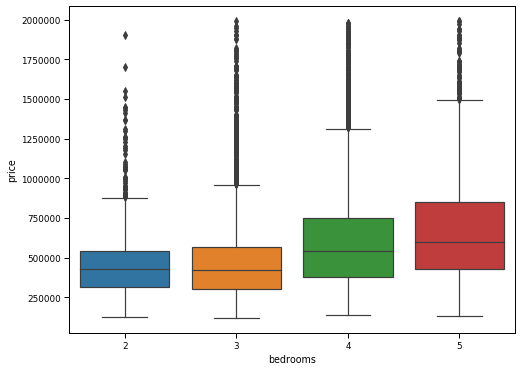

In [96]:
coefficients

plt.figure(figsize=(8,6))

sns.boxplot(x="bedrooms", y="price", data=kc2)


[None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None]

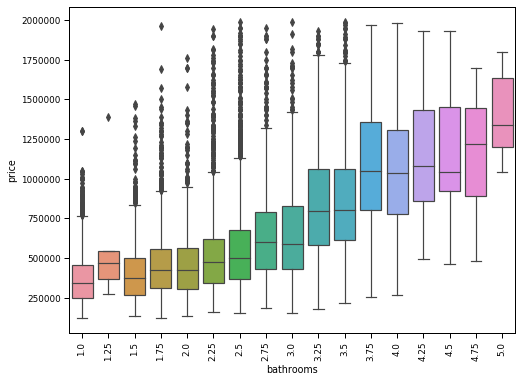

In [97]:
coefficients

plt.figure(figsize=(8,6))

ax = sns.boxplot(x="bathrooms", y="price", data=kc2)
plt.setp(ax.get_xticklabels(), rotation=90)


In [98]:
coefficients


[('sqft_living', 140.94600028379642),
 ('grade', 78037.90833279114),
 ('downtown_dist', -8845.882074783778),
 ('school_score', 38116.39475887594),
 ('view_4.0', 344191.5901786746),
 ('view_3.0', 170133.09222368588),
 ('view_2.0', 93477.37469634558),
 ('view_1.0', 99472.8084683562)]

In [99]:
kc_cont_log.describe()

price         grade   sqft_living  downtown_dist  school_score
count  1.891200e+04  18912.000000  18912.000000   18912.000000  18912.000000
mean   5.316017e+05      7.728374   2120.094913      14.450196      5.745505
std    2.819624e+05      1.074597    783.185193       8.544629      1.958564
min    1.207500e+05      4.000000   1008.000000       1.143239      2.000000
25%    3.340000e+05      7.000000   1520.000000       6.931178      4.000000
50%    4.645750e+05      8.000000   1970.000000      13.275852      6.000000
75%    6.500000e+05      8.000000   2560.000000      20.434790      8.000000
max    1.990000e+06     13.000000   5490.000000      70.824425      8.000000

# Additional plots for presentation

Text(0.5, 1, 'Price vs. Square Feet Living Space')

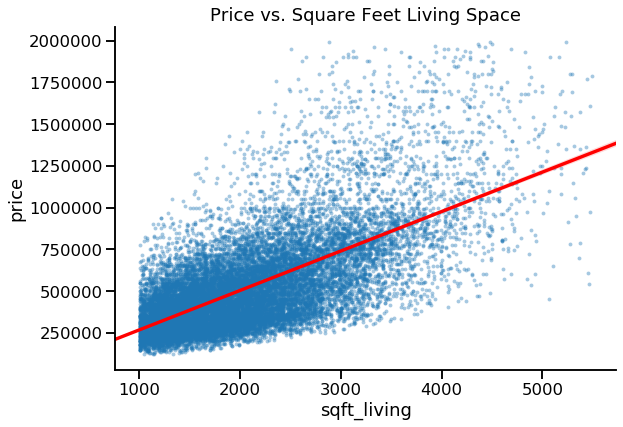

In [100]:
sns.set_context('talk')
sns.lmplot(x="sqft_living", 
            y="price", 
            data=kc_cont_log,
            scatter_kws={'alpha':0.4, 's':15, 'lw':0},
            line_kws={'color': 'red'},
            height=6,
            aspect=1.5
           )

ax = plt.gca()
ax.set_title('Price vs. Square Feet Living Space')


Text(0.5, 1, 'Price vs. Number of Bathrooms')

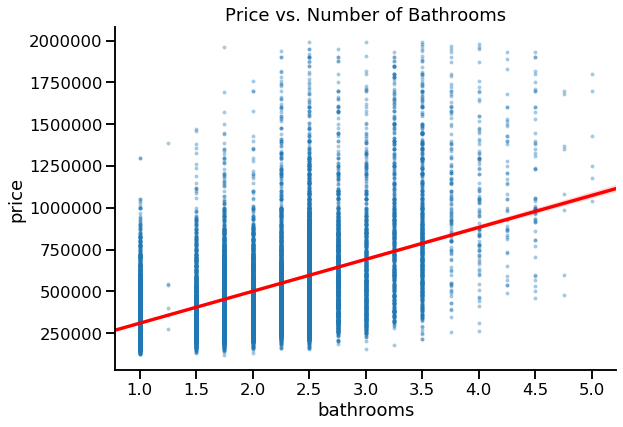

In [107]:
sns.set_context('talk')
sns.lmplot(x="bathrooms", 
            y="price", 
            data=kc2,
            scatter_kws={'alpha':0.4, 's':15, 'lw':0},
            line_kws={'color': 'red'},
            height=6,
            aspect=1.5
           )

ax = plt.gca()
ax.set_title('Price vs. Number of Bathrooms')

Text(0.5, 1, 'Price vs. Grade')

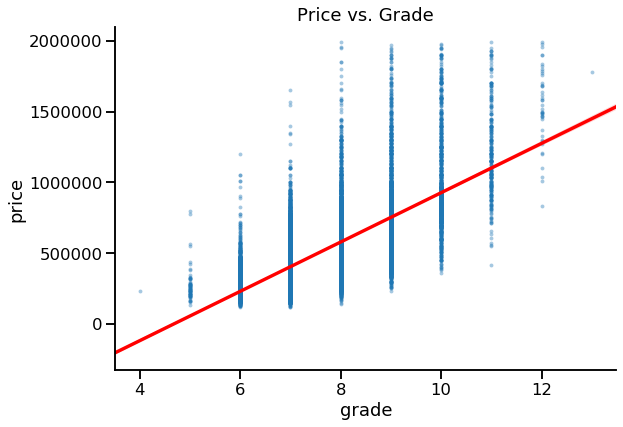

In [102]:
sns.set_context('talk')
sns.lmplot(x="grade", 
            y="price", 
            data=kc2,
            scatter_kws={'alpha':0.4, 's':15, 'lw':0},
            line_kws={'color': 'red'},
            height=6,
            aspect=1.5
           )

ax = plt.gca()
ax.set_title('Price vs. Grade')

Text(0.5, 1, 'Price vs. Bathrooms')

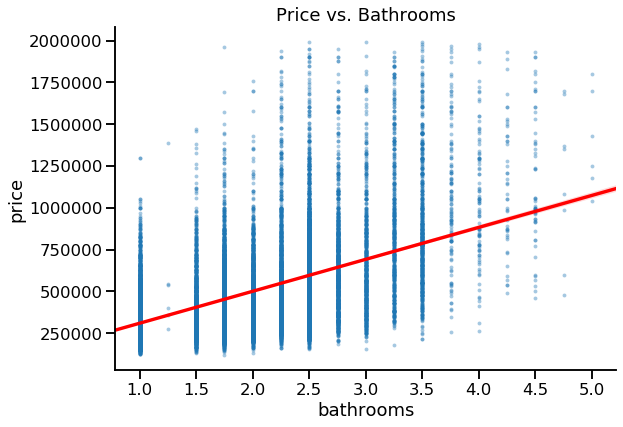

In [103]:
sns.set_context('talk')
sns.lmplot(x="bathrooms", 
            y="price", 
            data=kc2,
            scatter_kws={'alpha':0.4, 's':15, 'lw':0},
            line_kws={'color': 'red'},
            height=6,
            aspect=1.5
           )

ax = plt.gca()
ax.set_title('Price vs. Bathrooms')

Text(0.5, 1, 'Price vs. Bedrooms')

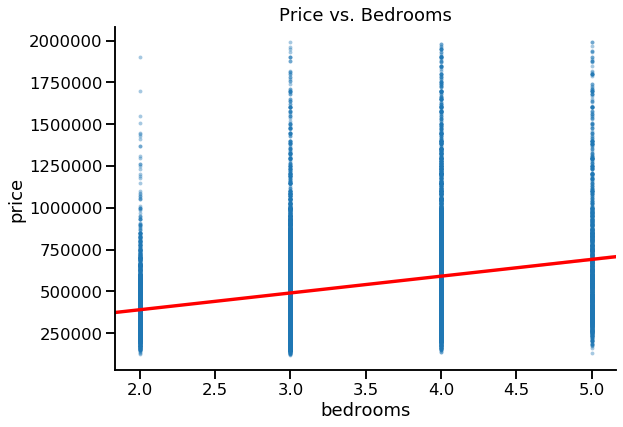

In [104]:
sns.set_context('talk')
sns.lmplot(x="bedrooms", 
            y="price", 
            data=kc2,
            scatter_kws={'alpha':0.4, 's':15, 'lw':0},
            line_kws={'color': 'red'},
            height=6,
            aspect=1.5
           )

ax = plt.gca()
ax.set_title('Price vs. Bedrooms')

Text(0.5, 1.0, 'Price vs. Bedrooms')

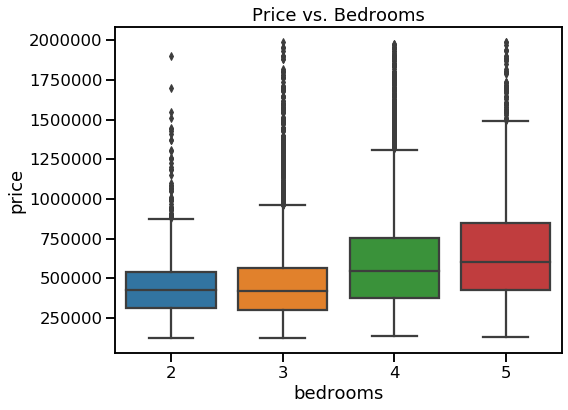

In [106]:
import seaborn as sns
plt.figure(figsize=(8,6))

ax = sns.boxplot(x="bedrooms", y="price", data=kc2)
#plt.setp(ax.get_xticklabels(), rotation=90)
ax.set_title('Price vs. Bedrooms')

In [116]:
kc2.view[kc2.view > 0].count()

1769